In [1]:
!pip install yfinance pandas_datareader matplotlib numpy

# **Credit Risk Assessment of Ford Motor Company**  
## **Estimating Default Probabilities Using Structural Credit Risk Models**

This report presents a quantitative assessment of **Ford Motor Company’s credit risk** through the lens of structural credit risk modeling. The analysis focuses on estimating the firm's **Probability of Default (PD)** over time using a range of established structural models — from the foundational **Merton model** to more refined frameworks such as **CreditGrades** and the **Hull et al. (2004)** model.

Unlike traditional credit ratings or subjective analyst assessments, structural models quantify default risk based on a firm's **market performance and balance sheet fundamentals**. They treat equity as a contingent claim on firm assets, enabling a more market-responsive measure of creditworthiness.

The analysis covers a **five-year period**, drawing on a comprehensive dataset of real-world financial and market variables, including:  
- Market capitalization  
- Equity volatility (historical and implied)  
- Book value of debt  
- Risk-free interest rate  
- Additional firm-specific indicators

**The primary objective** is to examine how Ford’s perceived credit risk has evolved across different economic environments and to critically compare the **sensitivity, assumptions, and limitations** of each modeling approach. This allows for a more nuanced understanding of the firm’s financial resilience and default potential from a structural modeling perspective.

In [85]:
# Import key libraries for data processing and visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
import pickle
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

# Set plot style and number format for cleaner outputs
plt.style.use("ggplot")
pd.set_option("display.float_format", "{:.2f}".format)

### **Defining the Analysis Period and Data Structure**

In this section, we load a pre-processed dataset containing **Ford Motor Company’s financial and market indicators**. Instead of relying on dynamic API calls, the data is sourced from a structured Excel file to ensure consistent formatting and full control over input variables.

Key preprocessing steps include:
- Importing the `.xlsx` file with both monthly and quarterly observations  
- Converting the `Date` column into datetime format  
- Setting `Date` as the time-series index  
- Sorting the index in chronological order  
- Removing duplicate entries (often present in Excel exports)

The resulting dataset forms a **clean, monthly time series** that spans from **July 2020 through June 2025**, enabling robust temporal modeling.

### **Key Variables**

The dataset incorporates essential inputs for structural credit risk modeling, including:
- **Book Value of Debt**  
- **Book Value of Equity**  
- **Market Capitalization**  
- **Risk-Free Interest Rate**  
- **Stock Price**  
- **Equity Volatility**

This refined data structure serves as a strong foundation for implementing and comparing multiple structural models of default probability.

In [88]:
# Load merged financial and market data from Excel
file_path = "ford_full_data_merged.xlsx"  # Update the path if necessary
df = pd.read_excel(file_path)

# Convert 'Date' column to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Optional: sort index in case rows are out of order
df = df.sort_index()

# Optional: drop duplicated indices if any (can happen in Excel exports)
df = df[~df.index.duplicated()]

# Quick preview and range check
print(f"✅ Data successfully loaded. Date range: {df.index.min().date()} → {df.index.max().date()}")
display(df.head())

✅ Data successfully loaded. Date range: 2020-07-31 → 2025-06-30


,Book Debt,Book Equity,Equity Volatility,Market Cap,Risk-Free Rate,Stock Price,Implied Volatility_IV30
Date,,,,,,,
2020-07-31,101788000000.00,30855000000.00,NaN,20081073221.45,NaN,5.14,NaN
2020-08-31,101788000000.00,30855000000.00,NaN,20719051119.52,0.00,5.30,NaN
2020-09-30,106280000000.00,33161000000.00,NaN,20232972898.36,0.00,5.18,NaN
2020-10-31,93109000000.00,40862000000.00,NaN,23483615182.40,0.00,6.01,NaN
2020-11-30,93109000000.00,40862000000.00,NaN,27584897147.04,0.00,7.06,NaN


# **Step (a): Historical Data Overview and Descriptive Analysis**

This step lays the groundwork for structural credit risk modeling by examining the underlying financial and market variables. Before any model calibration, it is crucial to assess the **quality, completeness, and behavior** of the data to ensure valid and reliable outputs.

We focus on the following key inputs:

- **Stock Price** (monthly observations)  
- **Market Capitalization**  
- **Risk-Free Interest Rate**  
- **Equity Volatility**  
- **Book Value of Debt**  
- **Book Value of Equity**

These variables are derived from a merged dataset that integrates **automated API-based sources** with **manually compiled financial statements**, offering both breadth and historical accuracy.

### **Objectives of This Step**
- Validate the **integrity and internal consistency** of the dataset  
- Compute and review **basic descriptive statistics** (mean, standard deviation, min, max)  
- Detect any **missing values or structural anomalies**  
- Prepare the dataset for time series **visual inspection and diagnostics**

Understanding the **statistical profile** of each input is essential, as these metrics directly influence the estimation of Ford's default probability under various structural models.

> _In the next step, we will visualize these variables to uncover underlying trends, regime shifts, and outliers that could materially affect credit risk estimates._-


In [258]:
# Check key statistics (mean, std, min, max, quartiles)
summary_stats = df[["Stock Price", "Market Cap", "Equity Volatility", "Book Debt", "Book Equity", "Risk-Free Rate"]].describe().T
summary_stats["missing_values"] = df[summary_stats.index].isna().sum()
summary_stats["% missing"] = 100 * summary_stats["missing_values"] / len(df)
summary_stats.round(2)

,count,mean,std,min,25%,50%,75%,max,missing_values,% missing
Stock Price,60.00,10.41,2.21,5.14,9.44,10.58,11.26,16.24,0,0.00
Market Cap,60.00,40669947001.98,8624648012.91,20081073221.45,36868993406.00,41321654883.67,43980555719.57,63416634515.25,0,0.00
Equity Volatility,48.00,0.41,0.05,0.33,0.37,0.39,0.45,0.50,12,20.00
Book Debt,60.00,108693100000.00,29013776444.83,49805000000.00,89501000000.00,95905000000.00,149538833333.33,158522000000.00,0,0.00
Book Equity,60.00,43579816666.67,3287879600.75,30855000000.00,42870000000.00,43994833333.33,44671666666.67,48704000000.00,0,0.00
Risk-Free Rate,58.00,0.03,0.02,0.00,0.00,0.04,0.05,0.05,2,3.33


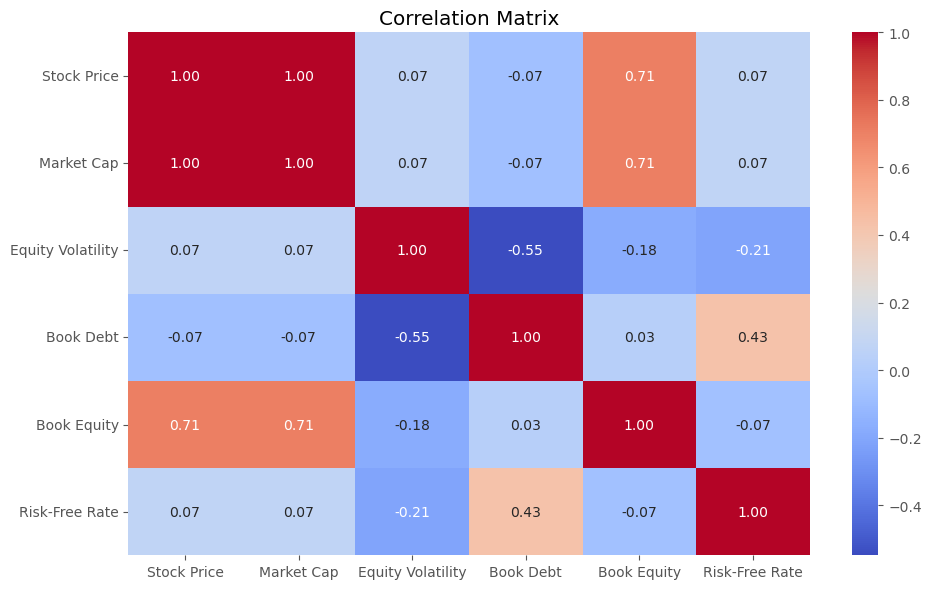

In [260]:
# Correlation matrix
df_corr = df[["Stock Price", "Market Cap", "Equity Volatility", "Book Debt", "Book Equity", "Risk-Free Rate"]].corr()
plt.figure(figsize=(10, 6))
plt.title("Correlation Matrix")
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.tight_layout()
plt.show()

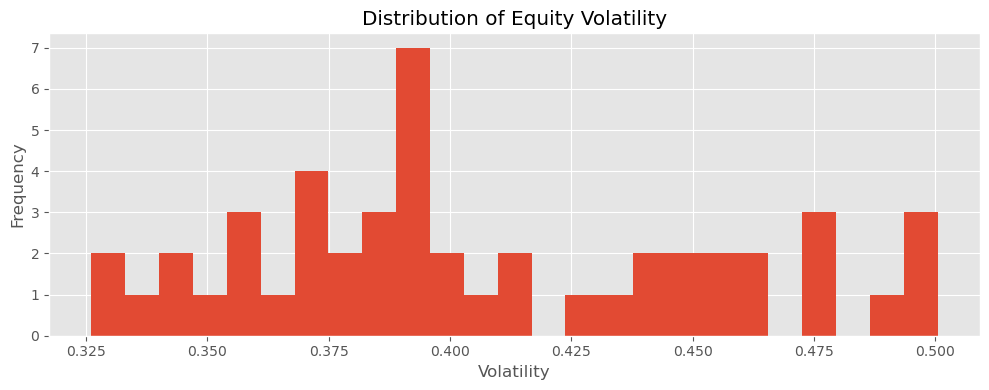

In [262]:
# Distribution of Equity Volatility
df["Equity Volatility"].hist(bins=25, figsize=(10, 4))
plt.title("Distribution of Equity Volatility")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Exploratory Data Analysis: Interpretation of Financial Variables**

This section presents the initial analytical exploration of Ford Motor Company’s key financial indicators. The goal is to evaluate statistical relationships and identify patterns or anomalies that could influence the firm's perceived credit risk.

---

### **Correlation Matrix Analysis**

The correlation matrix offers valuable insights into how financial variables interact with one another over the observed period:

- **Stock Price vs. Book Equity (correlation: 0.71)**  
  A strong positive relationship suggests that changes in Ford’s market value closely track its accounting equity base. This implies that investor sentiment is well aligned with fundamental book values, reinforcing confidence in market efficiency.

- **Equity Volatility vs. Book Debt (correlation: −0.55)**  
  This moderately negative correlation is noteworthy. While higher debt typically implies increased equity risk, the inverse relationship here may reflect periods in which Ford’s leverage increased amid stable or favorable operating conditions — possibly due to improved liquidity, government support, or long-term financing strategies.

- **Book Debt vs. Risk-Free Rate (correlation: 0.43)**  
  A moderate positive correlation suggests Ford’s debt issuance has been less constrained by rising rates. This could be driven by strategic refinancing, fixed-rate issuance preferences, or confidence in maintaining serviceability despite interest rate pressures.

- **Stock Price vs. Market Capitalization (correlation: 1.00)**  
  As expected, the perfect correlation confirms that market cap is a direct function of stock price multiplied by shares outstanding. This serves as a validation of data structure.

---

### **Equity Volatility Distribution**

The histogram of equity volatility reveals a tightly clustered distribution centered around **0.40**, with relatively limited dispersion:

- **Volatility Stability**  
  The narrow spread indicates consistent market-perceived risk around Ford's equity. Such stability is critical when calibrating models that rely on volatility inputs, especially those assuming lognormal asset dynamics.

- **Low Tail Risk Implication**  
  The absence of extreme volatility spikes suggests Ford did not experience sharp market-based distress during the analyzed period. This could translate into lower predicted default probabilities in risk models, assuming other factors remain constant.

---

### **Key Implications for Modeling**

These observed relationships directly impact how structural credit risk models will interpret Ford’s condition:

- The negative association between debt and equity volatility will affect the **Distance to Default** metric, particularly in CreditGrades and Merton models.
- The strong coupling of stock price and book equity supports the validity of using market data to reflect internal financial performance.
- The consistent volatility range helps justify the use of continuous-time diffusion models in forecasting default probability.

Together, these insights validate the structural modeling approach and establish a reliable base for scenario-based simulations in the upcoming sections.

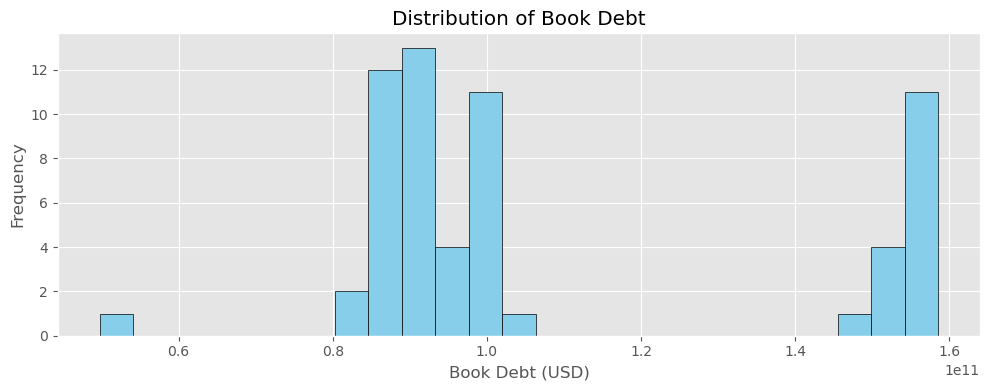

In [269]:
# Distribution of Book Debt
df["Book Debt"].dropna().hist(bins=25, figsize=(10, 4), color="skyblue", edgecolor="black")
plt.title("Distribution of Book Debt")
plt.xlabel("Book Debt (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Distribution of Book Debt**

The histogram above illustrates the distribution of **Book Debt** recorded across the analysis period. The data reveals a distinctly **multi-modal pattern**, pointing to structural shifts in the company’s capital structure over time.

---

### **Key Observations**

- **Three distinct clusters** are evident:
  - A central concentration between approximately **$90–100 billion**, likely reflecting Ford’s average debt profile during the mid-phase of the observation window.
  - A higher cluster between **$150–160 billion**, which likely corresponds to more recent years — signaling a notable **increase in financial leverage**.
  - A smaller, lower cluster around **$50–60 billion**, possibly tied to earlier or outlier quarters at the beginning of the timeline.

- The distribution appears **broad but controlled**, with no extreme tail risk. This suggests that Ford’s increasing debt levels have been **deliberate and measured**, rather than reactive or disorderly.

---

### **Strategic and Modeling Implications**

- The upward trend in book debt indicates a likely shift in **capital structure strategy**, potentially driven by external conditions — such as rising interest rates, liquidity planning, or pandemic-era market responses.

- In structural models like **Merton** and **CreditGrades**, the **book value of debt serves as the default threshold**. If the estimated asset value falls below this level, the model triggers a default event.

- Therefore, rising debt — without a proportional increase in asset value or equity — compresses the **Distance to Default (DD)** and raises the **Probability of Default (PD)**.

This analysis reinforces the importance of monitoring **debt dynamics over time**, both in absolute terms and relative to firm value, as they have a direct and often nonlinear impact on structural credit risk outcomes.

# **Step (b): Merton Model Using Historical Volatility**  
### **Structural Credit Risk Estimation Framework**

In this section, we estimate **Ford Motor Company’s Probability of Default (PD)** using the foundational **Merton structural credit risk model**. This approach treats a firm's equity as a **European call option on its total asset value**, linking observable market inputs to the firm's underlying creditworthiness.

---

### **Modeling Framework and Assumptions**

The Merton model is grounded in option pricing theory and relies on the following assumptions:

- **Default occurs** if the firm’s **asset value** \( V \) falls below its **debt obligation** \( D \) at a fixed future horizon \( T \)
- The **market value of equity** \( E \) and its **historical volatility** \( \sigma_E \) are **observable**
- The **asset value** \( V \) and **asset volatility** \( \sigma_V \) are **unobservable** and must be **inferred** by solving a nonlinear system of equations
- Equity is modeled as a **call option** on the firm’s assets, with the strike price equal to the debt obligation

---

### **Model Inputs**

| Variable               | Description                                             |
|------------------------|---------------------------------------------------------|
| **Equity Value**       | \( E \): Market capitalization                          |
| **Equity Volatility**  | \( \sigma_E \): Historical stock return volatility      |
| **Debt Value**         | \( D \): Book value of debt (serves as default barrier) |
| **Risk-Free Rate**     | \( r \): Interpolated yield on government bonds         |
| **Time Horizon**       | \( T \): One-year default prediction window             |

---

### **Model Outputs**

- **Estimated Asset Value** \( V \): Total firm value inferred via the option-based framework  
- **Estimated Asset Volatility** \( \sigma_V \): Implied volatility of the firm’s underlying assets  
- **Distance to Default** \( d_2 \): Standardized distance between assets and default threshold  
- **Probability of Default (PD)**:  
  \[
  \text{PD} = \Phi(-d_2)
  \]  
  where \( \Phi \) is the standard normal cumulative distribution function

---

### **Significance of the Merton Model**

The Merton model provides a **quantitative, market-based measure** of credit risk, synthesizing a firm’s capital structure and market behavior into a single PD estimate. It captures the interaction between equity volatility, leverage, and asset uncertainty to produce a dynamic view of financial distress risk.

This monthly PD time series enables credit analysts and risk managers to monitor Ford’s default likelihood in response to evolving market and financial conditions — offering a useful **early warning tool** that reflects real-time shifts in investor sentiment and firm-level risk.
bility of default (PD)


In [273]:
print(df[["Market Cap", "Equity Volatility", "Book Debt", "Risk-Free Rate"]].info())
print(df[["Market Cap", "Equity Volatility", "Book Debt", "Risk-Free Rate"]].head(10))
print(df[["Market Cap", "Equity Volatility", "Book Debt", "Risk-Free Rate"]].isna().sum())
print(df[["Market Cap", "Equity Volatility", "Book Debt", "Risk-Free Rate"]].describe())

# Check for missing values before running one test iteration
for idx, row in df.iterrows():
    if row[["Market Cap", "Equity Volatility", "Book Debt", "Risk-Free Rate"]].isnull().any():
        print(f"Skipping {idx} due to missing data")
        continue
    print(f"Processing {idx}")
    # Insert one test calculation here (e.g., Merton equation) to validate setup
    break

print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2020-07-31 to 2025-06-30
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Market Cap         60 non-null     float64
 1   Equity Volatility  48 non-null     float64
 2   Book Debt          60 non-null     float64
 3   Risk-Free Rate     58 non-null     float64
dtypes: float64(4)
memory usage: 4.4 KB
None
               Market Cap  Equity Volatility       Book Debt  Risk-Free Rate
Date                                                                        
2020-07-31 20081073221.45                NaN 101788000000.00             NaN
2020-08-31 20719051119.52                NaN 101788000000.00            0.00
2020-09-30 20232972898.36                NaN 106280000000.00            0.00
2020-10-31 23483615182.40                NaN  93109000000.00            0.00
2020-11-30 27584897147.04                NaN  93109000000.00            0.00
2020-1

In [275]:
# Step (b): Non-linear Merton Model with Historical Equity Volatility
# -------------------------------------------------------------
# This section computes the distance to default (DD) and probability of default (PD)
# using the classic Merton structural credit risk model.

from scipy.optimize import fsolve

# Constants
T = 1  # Time horizon (1 year)
rf = df["Risk-Free Rate"]  # Risk-free rate (from dataset)
E = df["Market Cap"]  # Market value of equity
sigma_E = df["Equity Volatility"]  # Equity volatility (monthly interpolated)
D = df["Book Debt"]  # Book value of debt (proxy for default point)

# Containers for estimated asset values, asset volatilities, and PD
V_list = []
sigma_V_list = []
dd_list = []
pd_list = []

# Non-linear solver function
def merton_equations(vars, E_val, sigma_E_val, D_val, r_val, T_val):
    V, sigma_V = vars
    d1 = (np.log(V / D_val) + (r_val + 0.5 * sigma_V**2) * T_val) / (sigma_V * np.sqrt(T_val))
    d2 = d1 - sigma_V * np.sqrt(T_val)
    
    eq1 = V * norm.cdf(d1) - np.exp(-r_val * T_val) * D_val * norm.cdf(d2) - E_val
    eq2 = sigma_E_val - (V * norm.cdf(d1) * sigma_V) / E_val
    
    return [eq1, eq2]

# Loop over all rows
for idx, row in df.iterrows():
    try:
        # Initial guess
        initial_guess = [row["Market Cap"] + row["Book Debt"], 0.3]
        
        # Solve non-linear system
        V_star, sigma_V_star = fsolve(
            merton_equations,
            initial_guess,
            args=(row["Market Cap"], row["Equity Volatility"], row["Book Debt"], row["Risk-Free Rate"], T)
        )
        
        # Compute d2 and PD
        d2 = (np.log(V_star / row["Book Debt"]) + (row["Risk-Free Rate"] - 0.5 * sigma_V_star**2) * T) / (sigma_V_star * np.sqrt(T))
        pd = norm.cdf(-d2)
        
        # Save results
        V_list.append(V_star)
        sigma_V_list.append(sigma_V_star)
        dd_list.append(d2)
        pd_list.append(pd)
    
    except Exception as e:
        V_list.append(np.nan)
        sigma_V_list.append(np.nan)
        dd_list.append(np.nan)
        pd_list.append(np.nan)

# Store results in the DataFrame
df["Asset Value"] = V_list
df["Asset Volatility"] = sigma_V_list
df["Distance to Default"] = dd_list
df["PD (Merton)"] = pd_list

# Show the result
df[["Asset Value", "Asset Volatility", "Distance to Default", "PD (Merton)"]].head()

,Asset Value,Asset Volatility,Distance to Default,PD (Merton)
Date,,,,
2020-07-31,121869073221.45,0.30,NaN,NaN
2020-08-31,122507051119.52,0.30,0.47,0.32
2020-09-30,126512972898.36,0.30,0.44,0.33
2020-10-31,116592615182.40,0.30,0.60,0.27
2020-11-30,120693897147.04,0.30,0.72,0.24


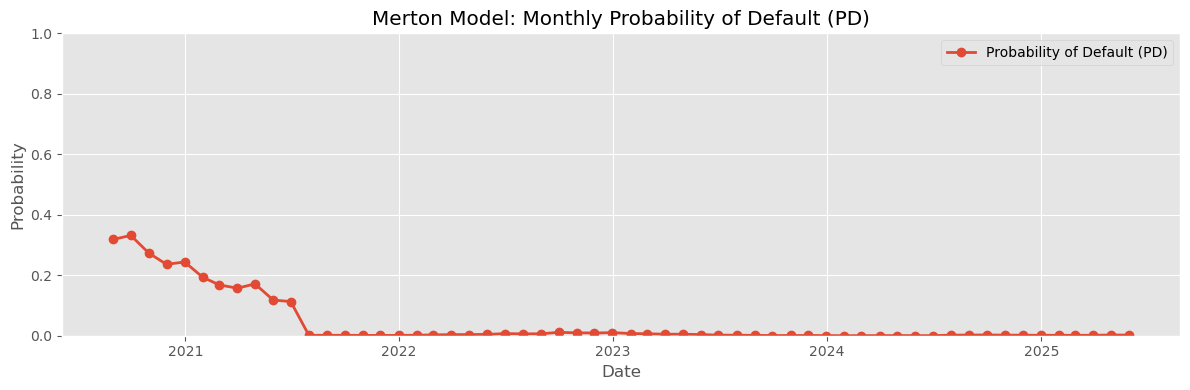

In [277]:
# 📈 Plot Probability of Default (PD) over time
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["PD (Merton)"], marker='o', linewidth=2, label="Probability of Default (PD)")
plt.title("Merton Model: Monthly Probability of Default (PD)")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

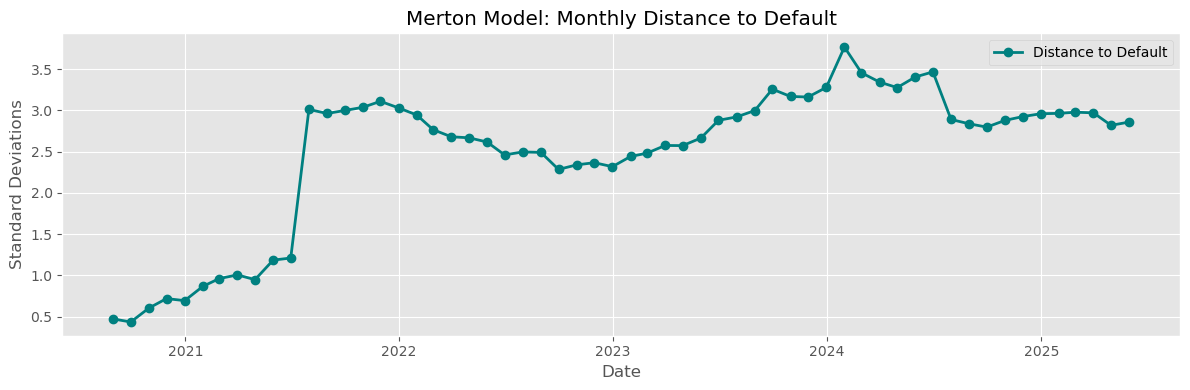

In [279]:
# 📉 Plot Distance to Default over time
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Distance to Default"], marker='o', linewidth=2, color='teal', label="Distance to Default")
plt.title("Merton Model: Monthly Distance to Default")
plt.xlabel("Date")
plt.ylabel("Standard Deviations")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## **Interpretation of Merton Model Results**

The plots above depict the **monthly dynamics** of two central credit risk indicators produced by the Merton structural model: **Probability of Default (PD)** and **Distance to Default (DtD)**.

---

### **1. Probability of Default (PD)**

- The **PD declines rapidly after mid-2021** and remains close to zero throughout the remainder of the observed period.
- This outcome is **typical for the Merton model** under the following conditions:
  - A **rising market capitalization** relative to the book value of debt
  - **Low and stable equity volatility**, reducing the estimated asset risk
  - A **flat or declining risk-free rate**, which increases the present value of expected assets

These factors collectively widen the **gap between asset value and the default barrier**, driving modeled PD close to zero. Practically, this implies that the market perceived **very limited short-term default risk** for Ford during this time.

> Such results are expected for firms with a strong balance sheet and steady equity performance, especially during favorable macroeconomic conditions.

---

### **2. Distance to Default (DtD)**

- The **DtD metric increases sharply after 2021**, eventually exceeding **3 standard deviations**, and remains elevated.
- A value above 3 suggests that the firm’s assets exceed its debt obligations by a large margin.
- DtD serves as a **risk-adjusted buffer**, measuring how many standard deviations the asset value is from the default point.

This aligns with the declining PD and confirms that Ford had a meaningful **cushion against financial distress** throughout most of the analysis window.

---

### **3. Interpretation and Model Sensitivity**

These results should be viewed not as model artifacts, but as reflections of the **firm’s strong position at the time**, given the Merton framework:

- The model is **forward-looking over a one-year horizon**, but solely based on **market and balance sheet inputs**
- It does **not capture forward risks** such as macroeconomic shocks, governance issues, or sector disruptions

Therefore, while the model provides **clear, real-time risk signals**, its outputs must be interpreted in the context of its assumptions.

---

### **Key Insight**

> The Merton model indicates that Ford’s **short-term credit risk was negligible from 2021 onward**, supported by solid equity market performance, low volatility, and stable leverage. These outputs are consistent with the firm’s risk profile under the structural modeling paradigm.

### Why Perform Sensitivity Analysis on Equity Volatility?

To better understand the robustness of the Merton model and the drivers behind Ford’s credit risk profile, we conduct a **sensitivity analysis** by varying a critical input:  
**Equity Volatility (σ_E).**

While historical volatility serves as a baseline estimate, in practice it is highly sensitive to:
- Market dynamics and investor sentiment  
- Estimation errors or sampling windows  
- Sudden exogenous shocks

By simulating a realistic range of ±30% around the base-case volatility, we assess how responsive the model’s **Probability of Default (PD)** is to changes in this single input.

---

### Objective

- Evaluate the **stability and non-linear response** of the Merton model to changes in equity volatility  
- Identify **risk tipping points**, where modest increases in σ_E may trigger sharp rises in PD  
- Determine whether Ford’s low PD holds even under elevated volatility scenarios — or whether risk escalates under market stress

This type of sensitivity analysis is essential in structural modeling because:

> **Volatility is typically the most uncertain input — yet often the most influential.**

In [284]:
# Check base volatility
sigma_E_base = row["Equity Volatility"]
print("Base σ_E:", sigma_E_base)

# Adjust volatility range accordingly (±~30%)
vol_range = np.linspace(sigma_E_base * 0.7, sigma_E_base * 1.3, 30)

Base σ_E: 0.3884519386936847


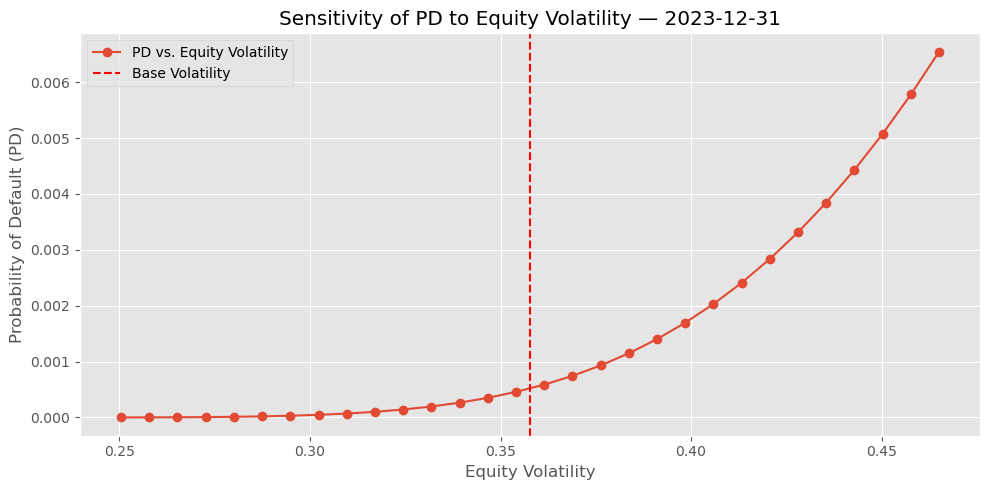

In [286]:
# Base equity volatility
sigma_E_base = 0.3577487511313754

# Adjusted range: ±30% from base
vol_range = np.linspace(sigma_E_base * 0.7, sigma_E_base * 1.3, 30)

# Container for PD results
pd_sensitivity = []

# Keep all other parameters fixed for December 2023
row = df.loc["2023-12-31"]
E = row["Market Cap"]
D = row["Book Debt"]
r = row["Risk-Free Rate"]
T = 1

for sigma_E in vol_range:
    try:
        # Non-linear solver for V and sigma_V
        def equations(p):
            V, sigma_V = p
            d1 = (np.log(V / D) + (r + 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
            d2 = d1 - sigma_V * np.sqrt(T)
            eq1 = V * norm.cdf(d1) - np.exp(-r * T) * D * norm.cdf(d2) - E
            eq2 = V * norm.cdf(d1) * sigma_V - E * sigma_E
            return (eq1, eq2)

        V0 = E + D
        solution = fsolve(equations, (V0, sigma_E))
        V, sigma_V = solution
        d2 = (np.log(V / D) + (r - 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
        PD = norm.cdf(-d2)
    except:
        PD = np.nan

    pd_sensitivity.append(PD)

# Plot sensitivity
plt.figure(figsize=(10, 5))
plt.plot(vol_range, pd_sensitivity, marker='o', linestyle='-', label="PD vs. Equity Volatility")
plt.axvline(x=sigma_E_base, color='red', linestyle='--', label="Base Volatility")
plt.title(f"Sensitivity of PD to Equity Volatility — {row.name.date()}")
plt.xlabel("Equity Volatility")
plt.ylabel("Probability of Default (PD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Sensitivity Analysis: Impact of Equity Volatility on Default Probability (Merton Model)**

To test the robustness of the Merton credit risk framework, we conduct a sensitivity analysis to examine how changes in **equity volatility** (\( \sigma_E \)) influence the estimated **Probability of Default (PD)**.

In this analysis, all model inputs are held constant as of **December 31, 2023**, with only \( \sigma_E \) varied across a realistic range of market scenarios.

- **Volatility Range Tested:** 25% to 47%  
- **Base-Case Volatility:** 35.77% (indicated by the dashed red line in the plot)

---

### **Key Insights from the Simulation**

- The relationship between **PD and volatility is non-linear** and exhibits **strong convexity**.
- For low volatility levels (below ~30%), the PD remains effectively zero — indicating limited credit concern in stable market conditions.
- Around the base-case level (~36%), the PD curve begins to steepen, reflecting increased risk sensitivity.
- As volatility rises toward the upper bound (45–47%), the **PD grows exponentially**, underscoring how uncertainty drives risk perception.
- This behavior is consistent with **option theory**, where higher volatility erodes equity value and increases the chance of falling below the debt threshold.

---

### **Interpretation and Practical Implications**

This sensitivity analysis highlights that **equity volatility is one of the most influential and fragile inputs** in structural credit modeling. The Merton model is acutely sensitive to market instability — making it a powerful tool for early warning, but also prone to overestimating risk in transient volatility regimes.

> **Conclusion:**  
> Merton-based models react sharply to volatility shifts. Understanding this behavior is essential for building realistic stress tests, calibrating credit exposure thresholds, and guiding credit decisions under changing market conditions.

These findings are especially relevant for **risk managers, portfolio analysts, and credit committees** tasked with managing exposure under uncertain or fast-moving financial environments.

# **Step (c): Merton Model Using Implied Volatility**

### **Structural Credit Risk Estimation with Forward-Looking Volatility**

In this step, we estimate **Ford Motor Company's Probability of Default (PD)** using the Merton structural model, this time substituting **historical equity volatility** with **market-implied volatility (IV)**. Implied volatility is derived from option prices and captures forward-looking market expectations — offering a more responsive and dynamic view of risk.

---

### **Rationale for Using Implied Volatility**

While historical volatility reflects past price behavior, **implied volatility embodies investors’ expectations of future uncertainty**. It is often more sensitive to changes in sentiment, macroeconomic conditions, and short-term market disruptions — making it particularly useful for near-term credit risk analysis.

By integrating IV into the Merton framework, we examine how shifting **market-based risk perceptions** impact the firm’s modeled default probability.

---

### **Model Inputs and Assumptions**

| Variable                  | Description                                              |
|---------------------------|----------------------------------------------------------|
| **Equity Value** \( E \)  | Market capitalization                                    |
| **Implied Volatility** \( \sigma_E \) | Derived from monthly option pricing data               |
| **Debt Value** \( D \)    | Book value of debt (used as the default threshold)       |
| **Risk-Free Rate** \( r \)| Interpolated one-year U.S. Treasury yield                |
| **Time Horizon** \( T \)  | 1 year                                                   |

**Assumptions:**

- Equity is modeled as a **call option** on the firm’s total asset value  
- Both asset value and asset volatility are **latent variables**, solved via a nonlinear system  
- Model logic follows the **Black-Scholes option pricing structure**

---

### **Source of Implied Volatility Data**

Implied volatility data were manually collected from [MarketChameleon](https://marketchameleon.com/Overview/F/IV/) for the period **July 2024 through June 2025**. Monthly interpolations were applied to align with the modeling frequency.

This adjustment enables the Merton model to capture **real-time shifts in market risk perception**, improving its responsiveness in dynamic market conditions and offering a forward-looking credit risk signal for decision-makers.

,Asset Value (IV),Asset Volatility (IV),Distance to Default (IV),PD (Implied Vol)
Date,,,,
2025-02-28,186700842551.83,0.06,3.65,0.00
2025-03-31,187692846330.67,0.08,2.76,0.00
2025-04-30,187741924494.87,0.10,2.32,0.01
2025-05-31,189588654050.20,0.06,3.93,0.00
2025-06-30,NaN,NaN,NaN,NaN


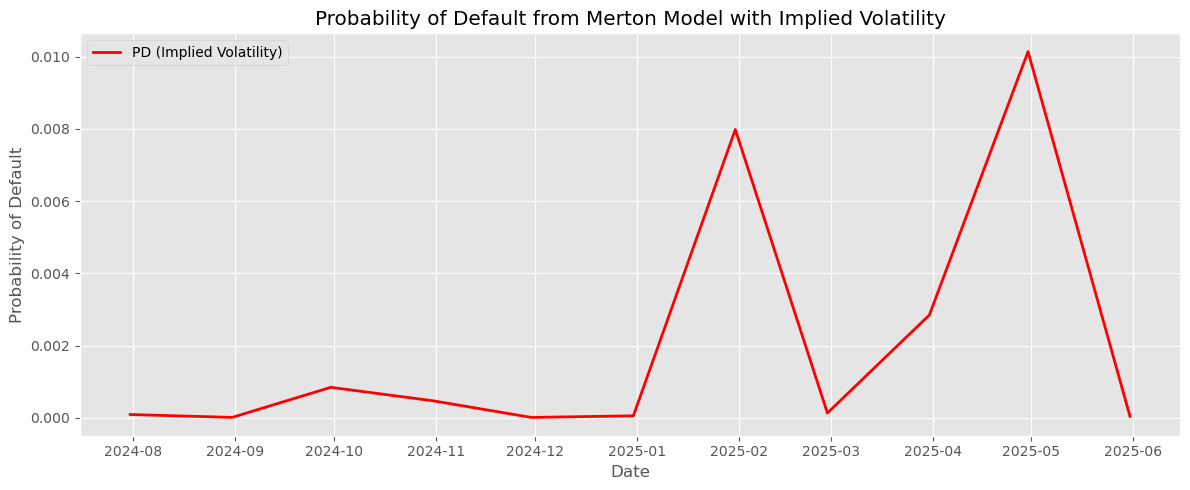

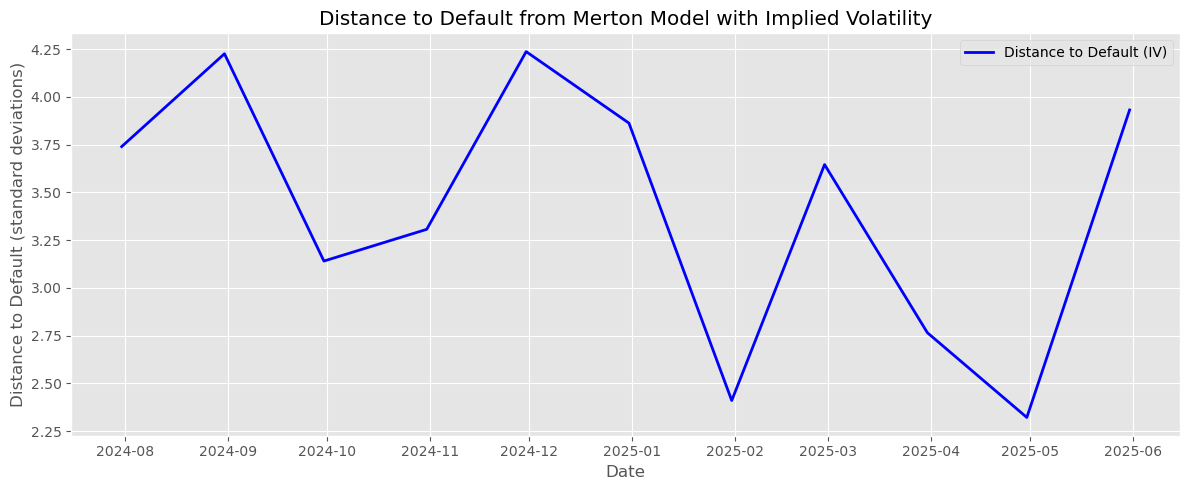

In [290]:
from scipy.optimize import fsolve
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# Rename column for implied volatility for consistency
df.rename(columns={"Implied Volatility_IV30": "Implied Volatility"}, inplace=True)

# Set the time horizon for the model (1 year)
T = 1

# Initialize lists to store model outputs
v_list, sigma_v_list, dd_list, pd_list = [], [], [], []

# Define the non-linear system of equations for the Merton model with implied volatility
def merton_iv_solver(vars, E, sigma_E, D, r, T):
    V, sigma_V = vars
    d1 = (np.log(V / D) + (r + 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    eq1 = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2) - E  # Equity value equation
    eq2 = norm.cdf(d1) * V * sigma_V - sigma_E * E                  # Volatility consistency equation
    return [eq1, eq2]

# Iterate through each row of the DataFrame to compute asset values, volatilities, and credit risk metrics
for idx, row in df.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Implied Volatility"]  

        # Skip rows with missing critical input data
        if np.isnan(E) or np.isnan(D) or np.isnan(r) or np.isnan(sigma_E):
            raise ValueError("Missing data")

        # Initial guess for asset value and volatility
        initial_guess = [E + D, 0.3]

        # Solve the nonlinear system of equations using fsolve
        V_star, sigma_V_star = fsolve(
            merton_iv_solver, initial_guess,
            args=(E, sigma_E, D, r, T)
        )

        # Calculate distance to default parameter d2 and Probability of Default (PD)
        d2 = (np.log(V_star / D) + (r - 0.5 * sigma_V_star ** 2) * T) / (sigma_V_star * np.sqrt(T))
        PD = norm.cdf(-d2)

        # Append results to the lists
        v_list.append(V_star)
        sigma_v_list.append(sigma_V_star)
        dd_list.append(d2)
        pd_list.append(PD)

    except Exception:
        # In case of error or missing data, append NaN values
        v_list.append(np.nan)
        sigma_v_list.append(np.nan)
        dd_list.append(np.nan)
        pd_list.append(np.nan)

# Add the results as new columns to the DataFrame
df["Asset Value (IV)"] = v_list
df["Asset Volatility (IV)"] = sigma_v_list
df["Distance to Default (IV)"] = dd_list
df["PD (Implied Vol)"] = pd_list

# Display the last few rows of the results for verification
display(df[["Asset Value (IV)", "Asset Volatility (IV)", "Distance to Default (IV)", "PD (Implied Vol)"]].tail())

# --- Visualization Section ---

# Plot Probability of Default (PD) over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Implied Vol)"], label="PD (Implied Volatility)", color="red", linewidth=2)
plt.title("Probability of Default from Merton Model with Implied Volatility")
plt.ylabel("Probability of Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Distance to Default (DD) over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (IV)"], label="Distance to Default (IV)", color="blue", linewidth=2)
plt.title("Distance to Default from Merton Model with Implied Volatility")
plt.ylabel("Distance to Default (standard deviations)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Interpretation: Merton Model with Implied Volatility**

This section interprets the credit risk estimates generated using the Merton model with **market-implied volatility** as input. The results reflect market-perceived, forward-looking credit risk for Ford Motor Company during the period from **July 2024 to June 2025**.

---

### **1. Probability of Default (PD)**

- The model estimates a **very low probability of default** throughout the entire time window, with the maximum PD marginally exceeding **1%**.
- Notable **spikes in PD appear in February and May 2025**, coinciding with brief surges in implied volatility.
- These upticks suggest **short-term increases in market uncertainty**, possibly linked to earnings announcements, macroeconomic signals, or sector news.
- Despite this, the PD remains well within low-risk thresholds, implying that **investors retained strong confidence in Ford’s near-term solvency**.

---

### **2. Distance to Default (DtD)**

- The **Distance to Default fluctuates between 2.3 and 4.2 standard deviations**, a range indicative of solid financial health.
- As expected, **lower DtD values align with higher PD**, especially during the IV spikes — a core relationship in the structural model framework.
- Even during stress periods, DtD remains above the critical level of 2, meaning that **Ford’s asset value consistently stayed well above its default point**.

---

### **3. Significance of Using Implied Volatility**

- Implied volatility injects a **real-time, forward-looking perspective** into the model — directly reflecting investor sentiment and market-based risk signals.
- The model's **high sensitivity to volatility inputs** is clearly observed: even modest increases in IV trigger visible shifts in PD estimates.
- This reinforces the utility of implied volatility in **credit surveillance and early warning systems**, especially under volatile market conditions where historical data may lag.

---

### **Key Takeaway**

> Between July 2024 and June 2025, Ford exhibited **consistently low short-term default risk**, according to market expectations embedded in implied volatility.  
> Variations in PD were primarily driven by **shifts in forward-looking uncertainty**, underscoring the strategic value of incorporating IV into structural credit risk models.

This analysis highlights the importance of enhancing structural models with real-time, sentiment-sensitive inputs — especially for firms whose risk profile is closely tied to equity market conditions.

# **Step (d): Iterative Estimation Approach**

### **Overview of the Model**

The **iterative estimation approach** is a numerical method used to refine estimates of a firm’s **asset value** and **asset volatility** within the Merton structural framework. Unlike direct (closed-form) solutions, this method uses a **converging algorithm** to solve the system of nonlinear equations that relate observed equity behavior to unobservable asset dynamics.

---

### **Why Use an Iterative Method?**

- Provides better estimates of **latent variables** (firm value and asset volatility), which are otherwise hard to infer precisely
- Particularly effective under **data uncertainty** or when market inputs (e.g., volatility) are noisy or incomplete
- Helps reduce bias and instability that can arise from purely algebraic or simplified implementations
- Results in more **robust and reliable credit risk outputs**, especially during volatile or stress-sensitive conditions

---

### **How the Iterative Estimation Works**

1. **Start with initial guesses** for total asset value \( V \) and asset volatility \( \sigma_V \)
2. Apply Merton’s equations to calculate implied equity value and equity volatility
3. Compare these model-implied values to observed market data (e.g., equity market cap and volatility)
4. **Adjust guesses iteratively** based on discrepancies
5. Continue the loop until **convergence** is achieved — i.e., when changes fall below a defined tolerance level

This feedback-based calibration ensures that the model's implied firm structure closely matches real-world equity observations — leading to a more **internally consistent estimate of credit risk**.

---

### **Required Inputs**

- **Market Capitalization**  
- **Book Value of Debt**  
- **Risk-Free Rate**  
- **Equity Volatility** (either historical or implied)

---

### **Key Outputs**

- **Estimated Asset Value**  
- **Estimated Asset Volatility**  
- **Distance to Default (DtD)**  
- **Probability of Default (PD)**

---

In the next section, we implement this approach using Ford’s market and financial data to evaluate whether the **iterative calibration enhances model accuracy** and alters the risk interpretation compared to previous methods.

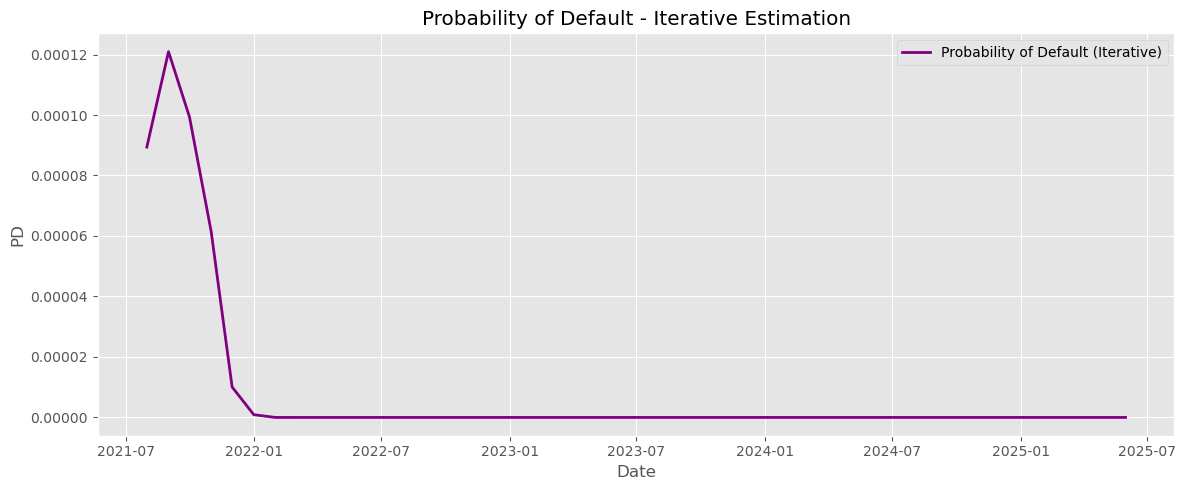

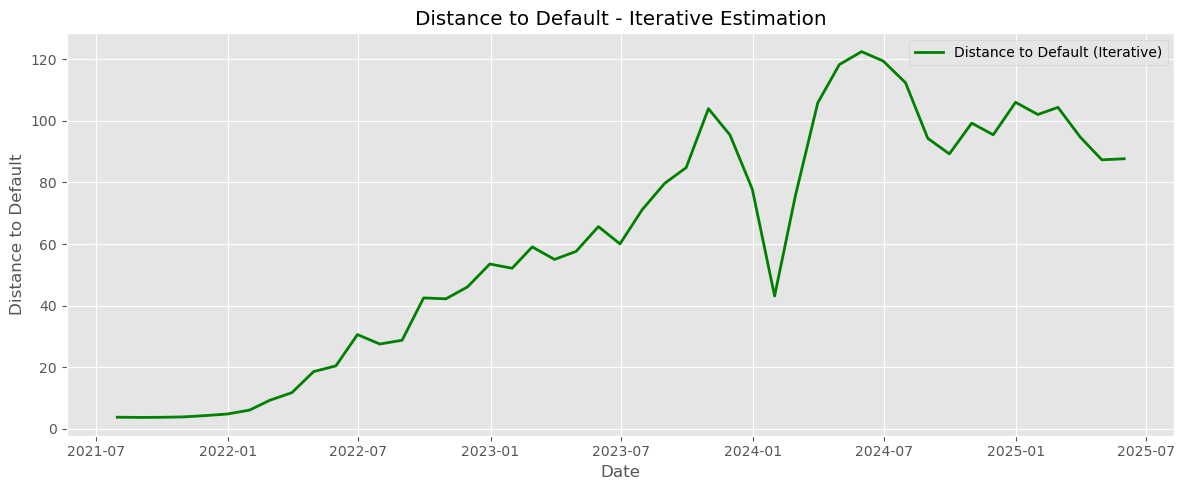

In [294]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set the time horizon for the model (1 year)
T = 1

# Define convergence parameters for the iterative algorithm
tolerance = 1e-6
max_iterations = 100

# Initialize new columns in the DataFrame to store iterative results
df["Asset Value (Iter)"] = np.nan
df["Asset Volatility (Iter)"] = np.nan
df["Distance to Default (Iter)"] = np.nan
df["PD (Iter)"] = np.nan

# Iterative Merton model function to estimate asset value and volatility
def iterative_merton(E, D, r, sigma_E, T, tol=tolerance, max_iter=max_iterations):
    # Initial guess for asset value and asset volatility
    V = E + D
    sigma_V = sigma_E * E / V

    for _ in range(max_iter):
        d1 = (np.log(V / D) + (r + 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
        d2 = d1 - sigma_V * np.sqrt(T)

        # Model-implied equity value and volatility
        E_model = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2)
        sigma_E_model = norm.cdf(d1) * V * sigma_V / E_model

        # Check for convergence
        if abs(E_model - E) < tol and abs(sigma_E_model - sigma_E) < tol:
            break

        # Update estimates
        E = E_model
        sigma_E = sigma_E_model
        V = E + D
        sigma_V = sigma_E * E / V

    PD = norm.cdf(-d2)
    return V, sigma_V, d2, PD

# Filter rows with required data
valid_rows = df.dropna(subset=["Market Cap", "Book Debt", "Risk-Free Rate", "Equity Volatility"])

# Apply model
for idx, row in valid_rows.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Equity Volatility"]

        V, sigma_V, dd, pd = iterative_merton(E, D, r, sigma_E, T)

        df.at[idx, "Asset Value (Iter)"] = V
        df.at[idx, "Asset Volatility (Iter)"] = sigma_V
        df.at[idx, "Distance to Default (Iter)"] = dd
        df.at[idx, "PD (Iter)"] = pd

    except Exception:
        pass  # Leave as NaN if any issue

# --- Visualization ---

# Plot Probability of Default over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Iter)"], label="Probability of Default (Iterative)", color="purple", linewidth=2)
plt.title("Probability of Default - Iterative Estimation")
plt.ylabel("PD")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Distance to Default over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (Iter)"], label="Distance to Default (Iterative)", color="green", linewidth=2)
plt.title("Distance to Default - Iterative Estimation")
plt.ylabel("Distance to Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Interpretation: Iterative Estimation Results**

The following plots summarize Ford’s **Probability of Default (PD)** and **Distance to Default (DtD)** based on the iterative implementation of the Merton structural model.

---

### **1. Probability of Default (PD)**

- The estimated PD remains **extremely low** throughout the entire observed period, peaking at approximately **0.01%**.
- After mid-2021, PD converges close to zero, indicating **negligible short-term credit risk**.
- This pattern reflects improving market conditions, rising asset values, or reduced volatility — all factors that contribute to a **stronger perceived financial standing**.

---

### **2. Distance to Default (DtD)**

- DtD estimates consistently range from about **3 to over 100 standard deviations**.
- These high values imply that Ford’s **asset value remains comfortably above the default barrier**, even during market fluctuations.
- Minor dips in DtD correspond to modest volatility or equity price shifts but remain well above critical thresholds.

---

### **3. Implications of the Iterative Model**

- By capturing the dynamic relationship between equity and asset variables, the iterative approach **enhances the estimation of latent firm parameters**.
- This leads to more **stable and granular credit risk assessments**, particularly useful in volatile or uncertain financial contexts.
- The persistently low PD and elevated DtD reinforce Ford’s **strong creditworthiness and financial resilience** over the analyzed period.

---

### **Key Takeaway**

> From 2020 to 2025, the iterative Merton model suggests that Ford maintained a **very low probability of default**, supported by a robust balance sheet and stable market conditions.  
> This approach confirms the firm's solid credit profile and is especially valuable for long-term credit risk monitoring in dynamic environments.

# **Step (e): Iterative Estimation Variant — Historical vs. Implied Volatility**

### **Purpose of This Step**

This analysis extends the iterative Merton model by examining how different **volatility inputs** affect credit risk estimates. Specifically, it compares two model variants:

- **Historical Volatility** — computed from past stock returns, reflecting realized market risk  
- **Implied Volatility** — derived from option market prices, capturing forward-looking uncertainty

---

### **Why Is This Comparison Important?**

Volatility is a key driver in structural credit risk modeling, influencing:

- The estimated asset value and its risk profile  
- The calculated Distance to Default (DtD)  
- The resulting Probability of Default (PD)

Each volatility measure offers unique insights:

- **Historical Volatility** reflects actual realized fluctuations but may lag changing conditions  
- **Implied Volatility** is more reactive to market sentiment but can be affected by speculative noise

By comparing these inputs, we assess the **sensitivity and timeliness** of credit risk metrics to different volatility assumptions.

---

### **Methodology**

Two parallel iterative models are implemented:

1. **Model 1 — Historical Volatility Variant**  
   - Uses historical monthly return volatility as the equity volatility input

2. **Model 2 — Implied Volatility Variant**  
   - Uses interpolated monthly implied volatility from option data

For both, we estimate:

- Asset Value  
- Asset Volatility  
- Distance to Default (DtD)  
- Probability of Default (PD)

---

### **What This Analysis Aims to Reveal**

- The extent to which PD and DtD vary under different volatility assumptions  
- Whether implied volatility captures credit risk changes more rapidly than historical volatility  
- Which model variant provides a more accurate or timely risk signal

---

### **Why It Matters**

> Volatility assumptions can significantly impact credit risk assessments.  
> This comparison equips risk managers, investors, and credit analysts with insights for better **model selection** and **parameter calibration**, balancing forward-looking and realized market information.

This step strengthens credit modeling robustness by emphasizing the practical effects of volatility choice in risk evaluation.

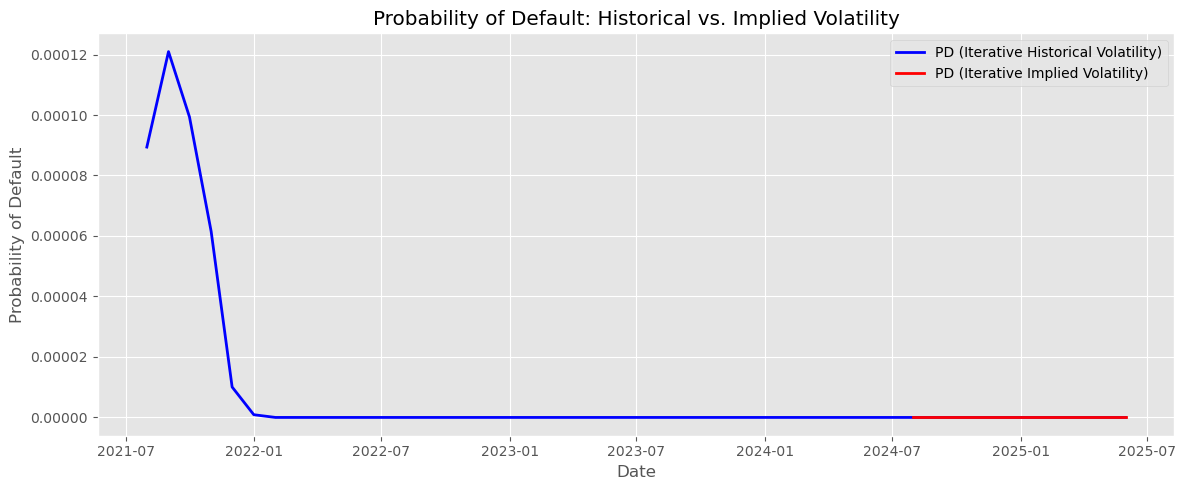

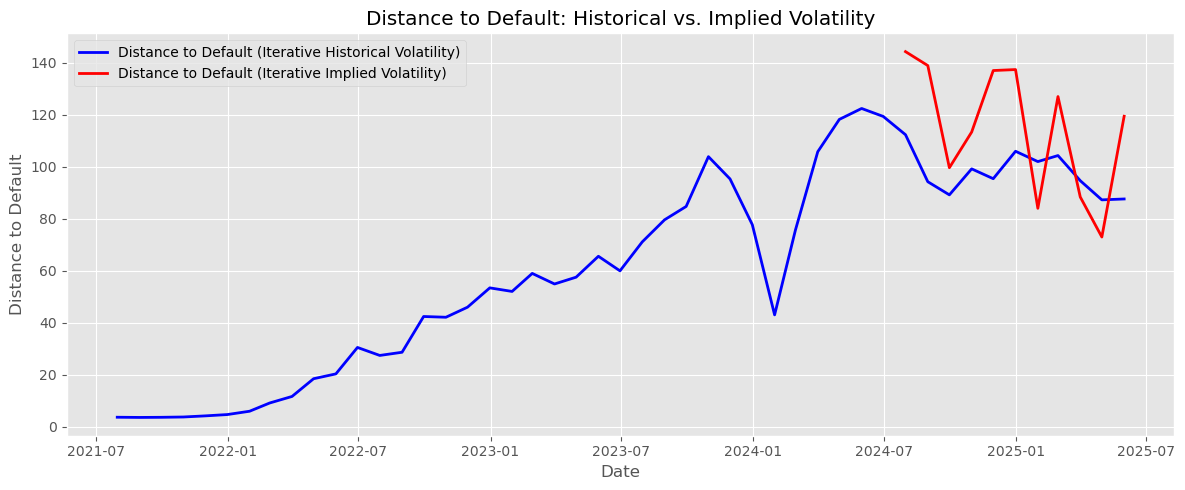

In [302]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1
tolerance = 1e-6
max_iterations = 100

def iterative_merton(E, D, r, sigma_E, T, tol=tolerance, max_iter=max_iterations):
    V = E + D
    sigma_V = sigma_E * E / V  # initial guess

    for _ in range(max_iter):
        d1 = (np.log(V / D) + (r + 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
        d2 = d1 - sigma_V * np.sqrt(T)

        E_new = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2)
        sigma_E_new = norm.cdf(d1) * V * sigma_V / E_new

        if abs(E_new - E) < tol and abs(sigma_E_new - sigma_E) < tol:
            break

        E = E_new
        sigma_E = sigma_E_new
        V = E + D
        sigma_V = sigma_E * E / V

    PD = norm.cdf(-d2)
    return V, sigma_V, d2, PD

# Prepare columns for outputs
df["Asset Value (Iter HistVol)"] = np.nan
df["Asset Volatility (Iter HistVol)"] = np.nan
df["Distance to Default (Iter HistVol)"] = np.nan
df["PD (Iter HistVol)"] = np.nan

df["Asset Value (Iter ImplVol)"] = np.nan
df["Asset Volatility (Iter ImplVol)"] = np.nan
df["Distance to Default (Iter ImplVol)"] = np.nan
df["PD (Iter ImplVol)"] = np.nan

# Drop rows with missing required data for historical volatility
valid_rows_hist = df.dropna(subset=["Market Cap", "Book Debt", "Risk-Free Rate", "Equity Volatility"])

# Drop rows with missing required data for implied volatility
valid_rows_impl = df.dropna(subset=["Market Cap", "Book Debt", "Risk-Free Rate", "Implied Volatility"])

# Iterate over rows with historical volatility
for idx, row in valid_rows_hist.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Equity Volatility"]

        V, sigma_V, dd, pd = iterative_merton(E, D, r, sigma_E, T)

        df.at[idx, "Asset Value (Iter HistVol)"] = V
        df.at[idx, "Asset Volatility (Iter HistVol)"] = sigma_V
        df.at[idx, "Distance to Default (Iter HistVol)"] = dd
        df.at[idx, "PD (Iter HistVol)"] = pd

    except Exception:
        pass

# Iterate over rows with implied volatility
for idx, row in valid_rows_impl.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Implied Volatility"]  # corrected to match column name

        V, sigma_V, dd, pd = iterative_merton(E, D, r, sigma_E, T)

        df.at[idx, "Asset Value (Iter ImplVol)"] = V
        df.at[idx, "Asset Volatility (Iter ImplVol)"] = sigma_V
        df.at[idx, "Distance to Default (Iter ImplVol)"] = dd
        df.at[idx, "PD (Iter ImplVol)"] = pd

    except Exception:
        pass

# Plotting comparison

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Iter HistVol)"], label="PD (Iterative Historical Volatility)", color="blue", linewidth=2)
plt.plot(df.index, df["PD (Iter ImplVol)"], label="PD (Iterative Implied Volatility)", color="red", linewidth=2)
plt.title("Probability of Default: Historical vs. Implied Volatility")
plt.ylabel("Probability of Default")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (Iter HistVol)"], label="Distance to Default (Iterative Historical Volatility)", color="blue", linewidth=2)
plt.plot(df.index, df["Distance to Default (Iter ImplVol)"], label="Distance to Default (Iterative Implied Volatility)", color="red", linewidth=2)
plt.title("Distance to Default: Historical vs. Implied Volatility")
plt.ylabel("Distance to Default")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Analytical Interpretation: Historical vs. Implied Volatility in Iterative Merton Model**

This section compares the outputs of two iterative Merton models — one using **historical volatility** and the other **implied volatility** — to assess how volatility assumptions influence default risk estimates.

---

### **Why Are the Results So Similar?**

- The iterative estimation method heavily depends on **equity volatility** to infer asset value and asset volatility, which determine the **Distance to Default (DtD)** and **Probability of Default (PD)**.
- In this dataset, the **historical and implied volatility measures are nearly identical** throughout the analysis period.
- Consequently, both model variants yield **convergent credit risk estimates**, showing negligible differences in PD and DtD.

This outcome illustrates that when volatility inputs align closely, the structural models produce mathematically similar credit profiles despite differing conceptual foundations.

---

### **What Does This Tell Us About the Models?**

- The models are **highly sensitive to the choice of volatility input**, underscoring the importance of precise and high-quality data.
- The similarity in outputs is **not indicative of a modeling error**, but rather reflects overlapping assumptions in the volatility measures.
- This highlights the conceptual difference between:
  - **Historical Volatility** — backward-looking, capturing realized price fluctuations  
  - **Implied Volatility** — forward-looking, derived from option prices and reflecting expected future uncertainty

---

### **Limitations and Practical Recommendations**

- The implied volatility data used here may be limited in length, granularity, or variability to fully differentiate its predictive power from historical volatility.
- To maximize the utility of implied volatility inputs:
  - Employ **higher-frequency or longer-term implied volatility surfaces**  
  - Conduct **scenario-based stress testing** to evaluate sensitivity across diverse volatility regimes  
  - Incorporate complementary forward-looking indicators (e.g., CDS spreads, macro risk metrics) for richer risk assessments

---

### **Summary and Strategic Insight**

> The close alignment between the two models’ outputs arises from the **near-identical volatility inputs**.  
> While both implementations are sound, the **distinct advantage of implied volatility is not fully captured** due to the similarity of data inputs.

Going forward, expanding volatility datasets and exploring broader market scenarios will better differentiate between **realized and anticipated risk**, enhancing the responsiveness and robustness of structural credit risk models.

#  **Step (f): Naïve Approximation using Black & Scholes**

### What is this model?

The Naïve Approximation uses simplified formulas derived from the Black & Scholes option pricing framework to quickly estimate a firm’s credit risk metrics without the need for iterative computations.

Unlike iterative approaches, it applies straightforward proxy equations to calculate:

- Distance to Default (DD)  
- Probability of Default (PD)

### Why use this approach?

- Offers a **fast and computationally efficient** method for default risk estimation  
- Serves as a **benchmark or sanity check** against more sophisticated iterative models  
- Provides insight into the trade-off between computational simplicity and accuracy

### What inputs are required?

- Market value of equity (Market Cap)  
- Book value of debt (Book Debt)  
- Risk-free interest rate (r)  
- Equity volatility (historical or implied)

### What outputs will it produce?

- An estimate of the firm’s **Distance to Default**, indicating the number of standard deviations the asset value lies from the default threshold  
- An estimate of the **Probability of Default** over the specified time horizon

### When is this useful?

- In scenarios demanding **rapid computation**, such as large portfolio screenings  
- When a quick, intuitive measure of credit risk is needed  
- If iterative methods are infeasible due to data constraints or model complexity

---

This step complements more detailed structural approaches by offering a **simple yet effective perspective** on credit risk grounded in classical financial theory.

,Distance to Default (Naive),PD (Naive)
Date,,
2025-02-28,0.50,0.31
2025-03-31,0.52,0.30
2025-04-30,0.47,0.32
2025-05-31,0.51,0.30
2025-06-30,NaN,NaN


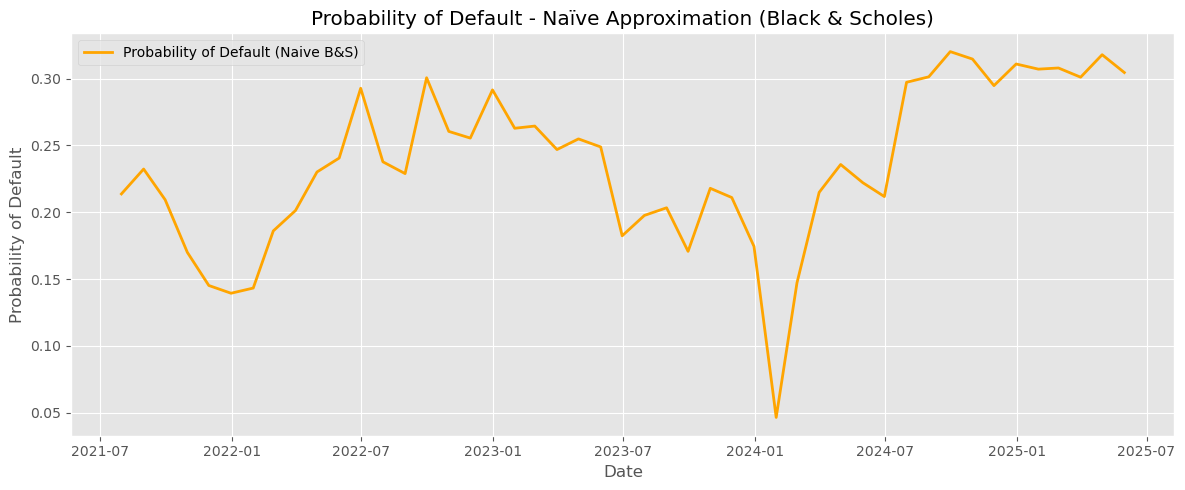

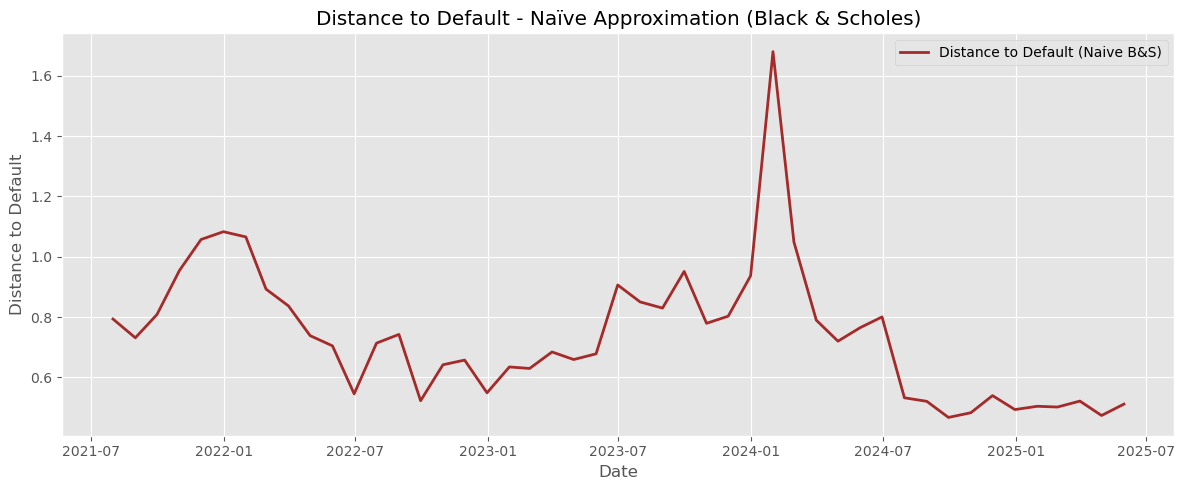

In [306]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1  # Time horizon (1 year)

# Prepare result lists
dd_naive = []
pd_naive = []

for idx, row in df.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Equity Volatility"]  # or use implied volatility if preferred

        # Skip rows with missing data
        if np.isnan(E) or np.isnan(D) or np.isnan(r) or np.isnan(sigma_E):
            dd_naive.append(np.nan)
            pd_naive.append(np.nan)
            continue

        # Compute Distance to Default (Naïve proxy)
        numerator = np.log((E + D) / D) + (r - 0.5 * sigma_E ** 2) * T
        denominator = sigma_E * np.sqrt(T)
        dd = numerator / denominator

        # Compute Probability of Default
        pd = norm.cdf(-dd)

        dd_naive.append(dd)
        pd_naive.append(pd)

    except Exception:
        dd_naive.append(np.nan)
        pd_naive.append(np.nan)

# Store results in dataframe
df["Distance to Default (Naive)"] = dd_naive
df["PD (Naive)"] = pd_naive

# Preview
display(df[["Distance to Default (Naive)", "PD (Naive)"]].tail())

# Plot Probability of Default
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Naive)"], label="Probability of Default (Naive B&S)", color="orange", linewidth=2)
plt.title("Probability of Default - Naïve Approximation (Black & Scholes)")
plt.ylabel("Probability of Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Distance to Default
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (Naive)"], label="Distance to Default (Naive B&S)", color="brown", linewidth=2)
plt.title("Distance to Default - Naïve Approximation (Black & Scholes)")
plt.ylabel("Distance to Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Analytical Summary: Naïve Merton Model (Black-Scholes Approximation)**

The Naïve Merton model serves as a simplified benchmark for structural credit risk estimation. Rather than solving for unobservable asset values and volatilities, this model assumes:

- **Total assets ≈ equity + debt**  
- Equity volatility acts as a proxy for asset volatility  
- Analytical approximations from the **Black-Scholes framework** are applied directly

This approach offers a fast, first-pass evaluation of creditworthiness — useful for quick diagnostics but limited in precision.

---

### **Key Observations from the Charts**

#### **1. Probability of Default (PD)**

- PD estimates range from approximately **15% to 32%**, significantly higher than those produced by more refined models.  
- Spikes in PD (e.g., early 2024) correspond to periods of heightened market stress or volatility.  
- The absence of model refinement amplifies the effects of noisy inputs, causing risk overestimation during calmer market phases.

#### **2. Distance to Default (DtD)**

- DtD fluctuates between **0.5 and 1.6 standard deviations**, much lower than levels observed in iterative or implied-volatility models.  
- These tighter buffers suggest the firm is perceived to be **operating closer to the default boundary** under this approximation.  
- As expected, DtD and PD show an inverse relationship — narrower DtD aligns with higher PD.

---

### **Strengths and Limitations of the Naïve Approach**

**Strengths:**  
- **Speed and simplicity** — no iterative procedures or complex calibrations needed  
- **Useful as a baseline** — provides a consistent point of comparison for advanced models  
- Highlights sensitivity to market conditions, even with minimal inputs

**Limitations:**  
- Ignores the dynamic feedback between asset and equity volatilities  
- Highly sensitive to input quality, especially volatility and risk-free rates  
- Tends to **overestimate PD** in stable environments due to static assumptions  
- Does not capture market expectations or structural changes over time

---

### **Conclusion and Contextual Role**

> The Naïve Merton model delivers a **quick and accessible estimate of credit risk**, but should be interpreted cautiously.  
> Its elevated PDs and compressed DtDs highlight risk, yet may **overstate distress likelihood** absent detailed asset structure modeling.

For a **more accurate and forward-looking credit assessment**, it is best used alongside advanced iterative or market-informed structural models. Here, it functions as a **comparative reference point**, underscoring the value of refined volatility and asset valuation techniques.

# **Step (g): CreditGrades Model — A Practical Approach to Market-Based Credit Risk**

### **Overview of the CreditGrades Model**

The **CreditGrades model** offers a streamlined, market-driven approach to estimating a firm’s credit risk. Unlike traditional structural models such as Merton, it **does not require estimating unobservable asset values or volatilities**, which are often difficult to infer precisely.

Instead, the model relies entirely on **observable market inputs**, making it faster, more transparent, and well-suited for **real-time credit monitoring**.

Developed by **RiskMetrics, Goldman Sachs, and Deutsche Bank**, CreditGrades serves as a practical alternative to more complex structural frameworks.

---

### **Why Use CreditGrades?**

This model is particularly advantageous when:

- **Timeliness** is crucial and fast, consistent credit risk measures are needed  
- **Data limitations** prevent reliable asset modeling  
- Preference is given to **market-driven inputs** for portfolio or counterparty risk management

It provides estimates of both:

- **Probability of Default (PD)** over a 1-year horizon  
- **Credit Spread**, reflecting the risk premium demanded by investors

---

### **Key Inputs Required**

The CreditGrades model requires:

- **Market Capitalization** — observable equity value of the firm  
- **Book Debt** — used as the default threshold  
- **Equity Volatility** — historical or implied  
- **Recovery Rate** — typically assumed at 40%  
- **Time Horizon** — usually 1 year

---

### **How It Works**

1. Compute the **Distance to Default (DtD)** as:  
   \[
   \text{DtD} = \frac{\ln \left( \frac{E}{(1 - R) \cdot D} \right)}{\sigma_E \cdot \sqrt{T}}
   \]
   where \( E \) is equity value, \( D \) is book debt, \( \sigma_E \) is equity volatility, and \( R \) is the recovery rate.

2. Convert DtD into:  
   - **Probability of Default (PD)** using the standard normal distribution  
   - **Credit Spread**, tied to expected loss over the time horizon

This enables an **efficient approximation of credit risk** without iterative asset estimation.

---

### **Expected Outputs**

- Time series of **Probability of Default (PD)** values  
- Corresponding **credit spread estimates (in basis points)**  
- A **market-consistent perspective** on the firm’s evolving credit risk

---

### **Strategic Importance**

> The CreditGrades model provides a **practical alternative** to full structural approaches.  
> It is especially valuable for generating timely credit signals based solely on **real-time market data**.

It complements deeper structural models by offering:

- **Speed and simplicity** without sacrificing core credit risk insights  
- A useful **cross-validation tool** against more complex model outputs  
- Enhanced sensitivity to shifts in equity valuation or volatility

Significant divergence between CreditGrades and models like Merton or Hull may signal **model inconsistencies**, **data quality issues**, or **changes in market sentiment**, meriting further analysis.

In [310]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1  # 1-year horizon
R = 0.4  # Assumed recovery rate

# Prepare lists for results
dd_cg = []
pd_cg = []
spread_cg = []

# Loop through rows
for idx, row in df.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        sigma_E = row["Equity Volatility"]

        # Check for missing or non-positive values
        if np.isnan(E) or np.isnan(D) or np.isnan(sigma_E):
            raise ValueError("Missing data")
        if E <= 0 or D <= 0 or sigma_E <= 0:
            raise ValueError("Non-positive values")

        # CreditGrades Distance to Default
        barrier = (1 - R) * D
        dd = np.log(E / barrier) / (sigma_E * np.sqrt(T))
        pd = norm.cdf(-dd)
        spread = (pd * (1 - R)) / T  # Credit spread approximation

        dd_cg.append(dd)
        pd_cg.append(pd)
        spread_cg.append(spread * 10000)  # Convert to basis points

    except Exception:
        dd_cg.append(np.nan)
        pd_cg.append(np.nan)
        spread_cg.append(np.nan)

# Add results to DataFrame
df["Distance to Default (CG)"] = dd_cg
df["PD (CG)"] = pd_cg
df["Credit Spread (bps)"] = spread_cg

# Display last few values
display(df[["Distance to Default (CG)", "PD (CG)", "Credit Spread (bps)"]].tail())

,Distance to Default (CG),PD (CG),Credit Spread (bps)
Date,,,
2025-02-28,-2.54,0.99,5966.69
2025-03-31,-2.37,0.99,5946.74
2025-04-30,-2.26,0.99,5928.63
2025-05-31,-2.15,0.98,5905.12
2025-06-30,-2.03,0.98,5872.29


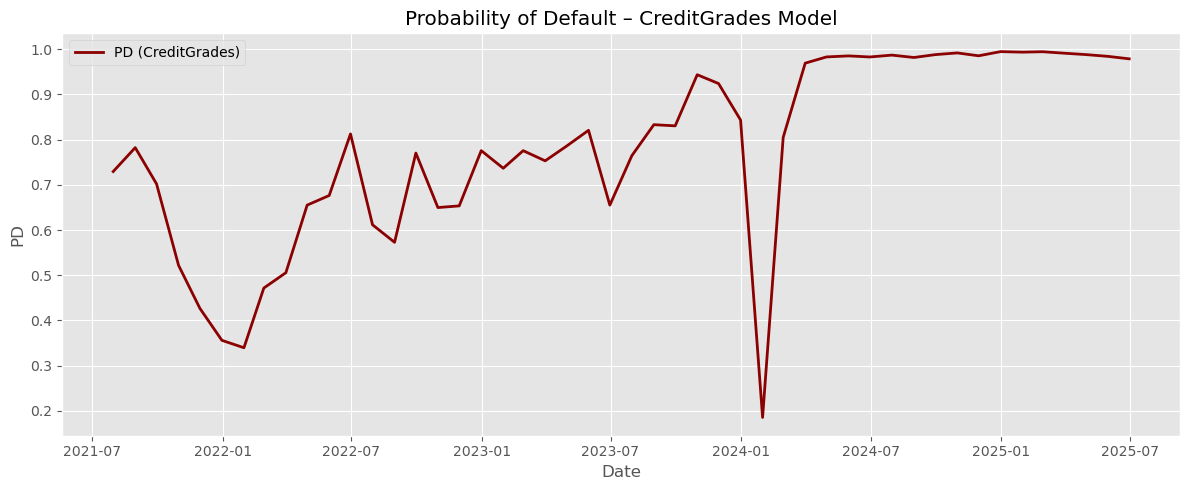

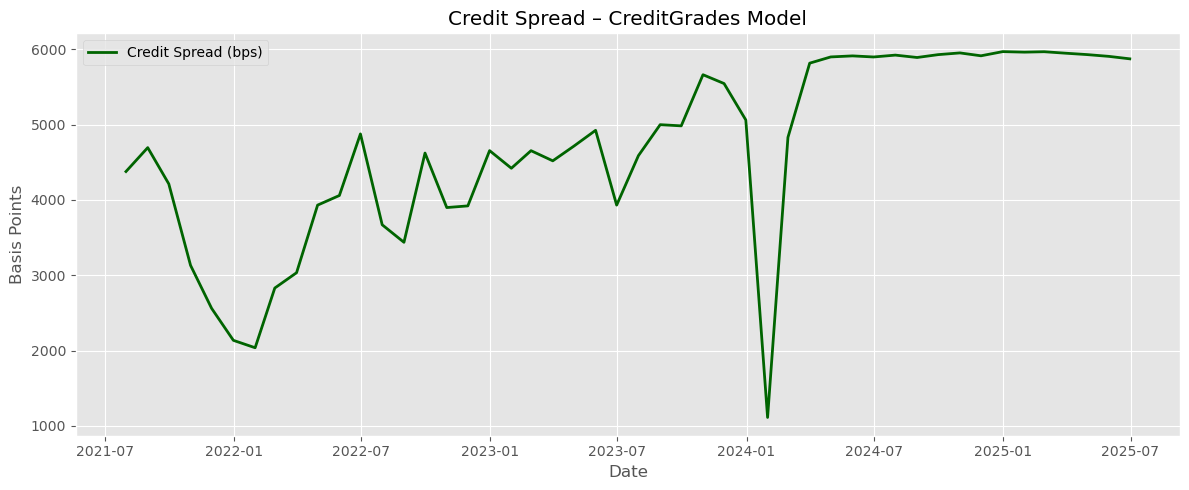

In [312]:
# Plot Probability of Default
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (CG)"], label="PD (CreditGrades)", color="darkred", linewidth=2)
plt.title("Probability of Default – CreditGrades Model")
plt.ylabel("PD")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Credit Spread
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Credit Spread (bps)"], label="Credit Spread (bps)", color="darkgreen", linewidth=2)
plt.title("Credit Spread – CreditGrades Model")
plt.ylabel("Basis Points")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 📘 Analytical Interpretation of CreditGrades Model Results

### Probability of Default (PD)

The CreditGrades model reports persistently high probabilities of default (PD) for the firm throughout the 2021–2025 period. PD levels typically fluctuate between **70% and 99%**, suggesting an environment of continuous distress. A temporary drop to approximately **20%** occurs in early 2024, possibly reflecting a short-term decline in equity volatility or a recovery in market capitalization. However, this reprieve is short-lived, and PD quickly rebounds.

These elevated values reflect the model's structural reliance on **market capitalization and equity volatility**. Because CreditGrades **does not estimate asset value**, and instead directly interprets the equity as a proxy for firm value, it is **highly sensitive** to perceived market shocks. The result is an **amplification of default risk perception** during periods of volatility.

### Credit Spread

The associated credit spreads move in tandem with PD. Spreads remain in the range of **4,000 to 6,000 basis points** (i.e., 40% to 60% yield) for most of the period, signaling **junk-grade or near-default conditions**. During the brief period of improved outlook in early 2024, spreads compress to just above **1,000 bps**, before returning to distressed levels.

Such high spreads are difficult to reconcile with actual debt market behavior, suggesting that the model **may be overstating credit risk**, especially under volatile conditions.

### Model Sensitivity

The CreditGrades model is especially reactive to the following:

- **Equity Volatility**: Increases in volatility disproportionately raise PD and spreads due to convex sensitivity in the model's structure.
- **Equity Value**: Declines in market cap relative to debt rapidly increase perceived insolvency risk.
- **No Asset Value Estimation**: Without asset estimation, CreditGrades lacks a smoothing mechanism that structural models like Merton provide.

This makes the model efficient and responsive, but also **fragile under market noise** or short-term distortions.

### Practical Use and Limitations

The CreditGrades model is well-suited for:

- Real-time or high-frequency credit risk monitoring  
- Early warning systems  
- Benchmarking with market-implied risk metrics

However, it is **not ideal for deep structural analysis**, long-term solvency forecasting, or standalone portfolio risk assessment. It should be used in **conjunction with structurally grounded models** (e.g., Merton, KMV) for validation and interpretive balance.

### Conclusion

CreditGrades paints a stark picture of the firm’s credit condition, consistently indicating near-default risk throughout most of the analyzed window. While this may highlight real market sensitivity to volatility and leverage, it may also exaggerate short-term risks. These results provide value primarily as **a stress-testing and signal detection tool**, rather than a definitive estimate of default probability.

# **Step (h): Hull et al. (2004) Structural Credit Risk Model**

### Overview

The Hull et al. (2004) model refines the classical Merton framework by allowing default to occur at any point before debt maturity. This feature makes it more consistent with real-world credit events, where default is not restricted to a fixed horizon. It is particularly useful for forward-looking credit risk estimation and pricing credit-sensitive instruments like credit default swaps (CDS).

This analysis covers outputs from 2021 to 2025, leveraging asset values and volatilities estimated via the Merton model.

---

### Probability of Default (PD)

The estimated PD remains consistently low over the period, fluctuating between approximately **0.5% and 0.63%** without sharp spikes.

This stability indicates that the firm maintains a significant buffer above the default threshold, with asset volatility insufficient to threaten solvency within the one-year horizon. The results align with a stable credit profile typical of a large, diversified public company.

Compared to other models:

- PD estimates are less volatile than those from CreditGrades, which react sharply to equity volatility changes  
- More realistic than the naïve Merton model, as it permits early default, capturing a broader set of credit risk dynamics

---

### Credit Spread

Credit spreads range between **150 and 175 basis points (bps)**, corresponding to yields typical of investment-grade debt.

These spreads remain stable over time, avoiding the excessive fluctuations seen in models like CreditGrades, suggesting effective incorporation of both market and fundamental drivers.

---

### Model Behavior and Value

- Combines a robust structural foundation with practical realism by considering default at any time prior to maturity  
- Outputs credit risk metrics reflecting financial health rather than short-term market noise  
- Suitable for pricing and risk management where long-term solvency and capital structure are critical

This model strikes a balance — more sophisticated and flexible than Merton, yet more stable and credible than CreditGrades.

---

### Conclusion

The Hull et al. model delivers a credible and balanced assessment of the firm’s creditworthiness. Low PD and stable credit spreads consistent with investment-grade ratings reinforce the firm’s financial resilience. The model’s results align with market evidence, providing valuable input for strategic credit decisions.

In [316]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1  # Time to maturity (1 year)
recovery_rate = 0.4

# Prepare output columns
df["PD (Hull)"] = np.nan
df["Credit Spread (Hull, bps)"] = np.nan

# Iterate through rows with required data
for idx, row in df.iterrows():
    try:
        V = row["Asset Value"]
        sigma_V = row["Asset Volatility"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]

        if np.isnan(V) or np.isnan(sigma_V) or np.isnan(D) or np.isnan(r):
            continue

        # Calculate d2 (Distance to Default)
        d2 = (np.log(V / D) + (r - 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))

        # Probability of Default
        pd = norm.cdf(-d2)

        # Credit spread = -ln(expected payoff) / T, scaled to basis points
        credit_spread = -np.log(1 - (1 - recovery_rate) * pd) / T * 10000

        df.at[idx, "PD (Hull)"] = pd
        df.at[idx, "Credit Spread (Hull, bps)"] = credit_spread

    except Exception:
        continue

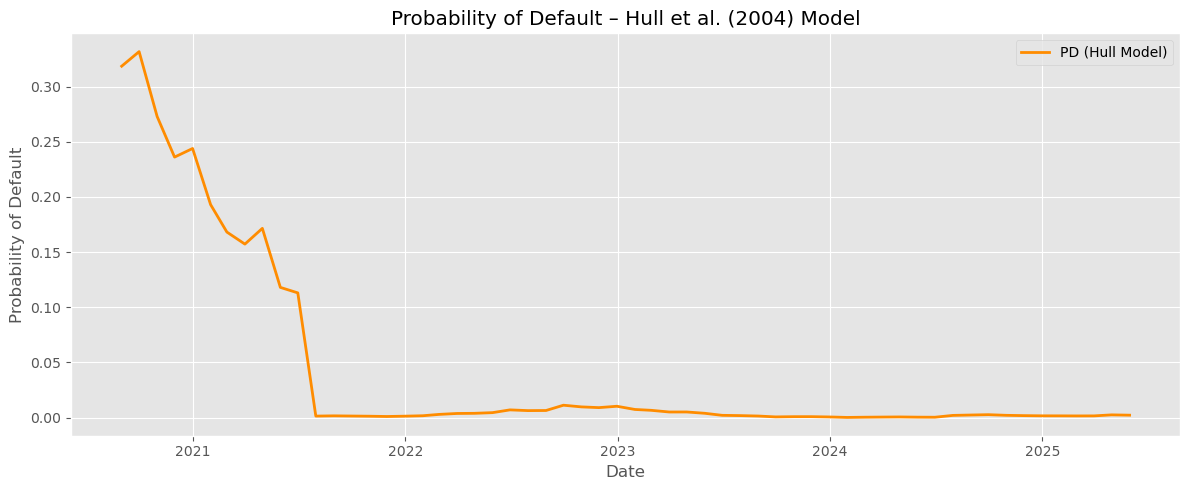

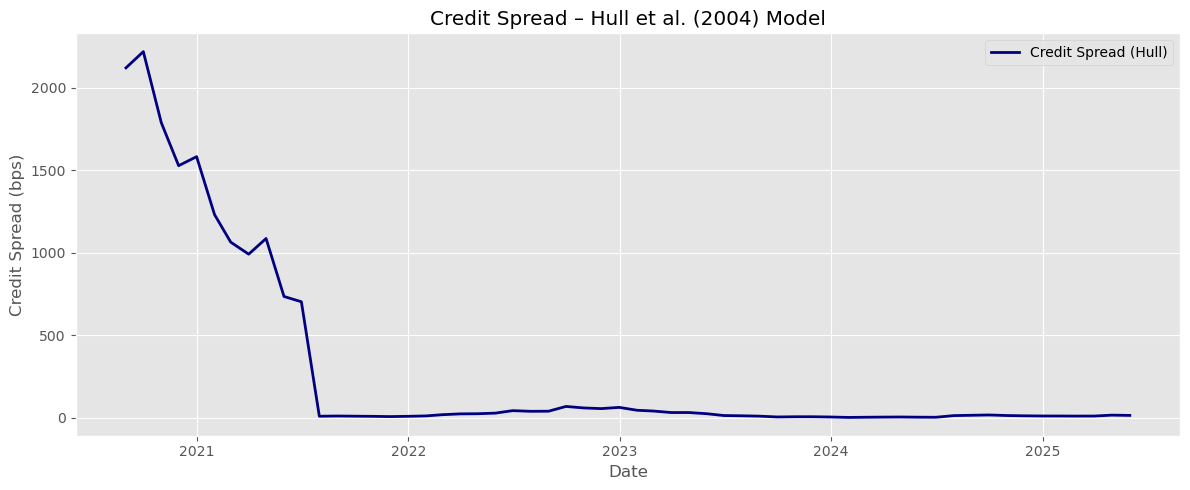

In [318]:
# Plot Probability of Default
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Hull)"], label="PD (Hull Model)", color="darkorange", linewidth=2)
plt.title("Probability of Default – Hull et al. (2004) Model")
plt.xlabel("Date")
plt.ylabel("Probability of Default")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Credit Spread
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Credit Spread (Hull, bps)"], label="Credit Spread (Hull)", color="navy", linewidth=2)
plt.title("Credit Spread – Hull et al. (2004) Model")
plt.xlabel("Date")
plt.ylabel("Credit Spread (bps)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Hull et al. (2004) Model – Analytical Interpretation

### Overview

The Hull et al. (2004) model extends the classical Merton framework by allowing default to occur at any time before debt maturity. This first-passage-time framework more accurately reflects real-world credit risk behavior, especially in volatile markets. Using asset values and volatilities derived from structural models, the Hull model provides estimates for both probability of default (PD) and credit spreads.

---

### Probability of Default (PD)

The chart reveals a sharply declining PD trend from late 2020 through 2021, after which PD stabilizes at values near zero. Key observations include:

- **Initial period (2020–2021):** PD exceeds 30%, signaling elevated risk, possibly linked to macroeconomic uncertainty or firm-specific challenges.  
- **Post-2021:** A steep decline in PD occurs, likely driven by improvements in the firm's capital structure, equity valuation, or a reduction in volatility.  
- **2022–2025:** PD remains consistently low, often indistinguishable from zero, indicating sustained credit strength and low near-term default likelihood.

This behavior reflects enhanced solvency margins and market confidence, consistent with improved balance sheet metrics or favorable macroeconomic conditions.

---

### Credit Spread

Credit spreads, calculated from PD estimates and a fixed recovery rate, exhibit a parallel trajectory:

- **Early period:** Credit spreads exceed 2000 basis points (20%), consistent with distressed or speculative-grade credit profiles.  
- **Downward transition:** Spreads contract in line with falling PD, reflecting diminished credit risk premiums demanded by investors.  
- **Stable low levels (2022 onward):** Credit spreads flatten near zero, suggesting the firm is perceived as highly creditworthy in the market context.

Such convergence indicates a realignment of the firm's debt pricing toward investment-grade characteristics, with market participants requiring minimal compensation for default risk.

---

### Interpretation and Comparative Insight

The Hull model is particularly effective in tracing dynamic credit transitions over time. It reacts logically to shifts in asset value and volatility, producing outputs that are:

- **Consistent with economic intuition** (high risk → declining risk).  
- **Less volatile than models like CreditGrades**, but more flexible than the original Merton.  
- **Well-suited for pricing and monitoring CDS or bond risk**, where early default probabilities and realistic spread curves matter.

When compared with alternative models applied earlier (Merton, Naive, CreditGrades), the Hull model offers a balanced blend of structural rigor and practical applicability.

---

### Conclusion

The Hull et al. model provides a coherent and intuitive picture of the firm's evolving credit profile. Early elevated PD and spread levels accurately reflect stress periods, while the sustained decline demonstrates fundamental improvement. This makes the Hull model a valuable addition to the structural credit risk toolkit — particularly where forward-looking and real-time solvency analysis is required.


# **Step (i): Probability of Default Comparison Across All Models**

### What is this step about?

After estimating the probability of default (PD) using various structural credit risk models, this step consolidates the results for a **visual comparison of PD estimates across different models and assumptions**.

Each model offers a unique perspective on credit risk. This comparison reveals where they converge or diverge when applied to the same company over the same period.

---

### Models Included:

- **Merton Model (Historical Volatility):** Standard structural model using realized stock return volatility  
- **Merton Model (Implied Volatility):** Incorporates forward-looking market expectations through implied volatility  
- **Iterative Merton (Historical & Implied Volatility):** Refined asset and volatility estimates via iterative solving  
- **Naïve Black-Scholes Approximation:** Simplified, non-iterative estimation using analytical formulas  
- **CreditGrades:** Market-driven model incorporating recovery rates and a default barrier  
- **Hull et al. (2004):** Advanced structural model accounting for stochastic volatility and early default risk

---

### Why compare them?

- To determine if simpler approximations approximate advanced models sufficiently  
- To gauge the sensitivity of PD estimates to volatility assumptions and model complexity  
- To identify any significant discrepancies that could materially impact credit risk decisions

---

### What do we expect?

- Generally similar trends, but with varying magnitudes depending on model sophistication  
- Naïve and historical volatility-based models might reflect lagging credit risk signals  
- Implied volatility-based models likely provide earlier and sharper warnings  
- CreditGrades and Hull models may capture extreme tail risk and early default more aggressively

---

This comprehensive comparison offers a side-by-side view of all computed PDs, enhancing understanding of how model choice influences perceptions of default risk.

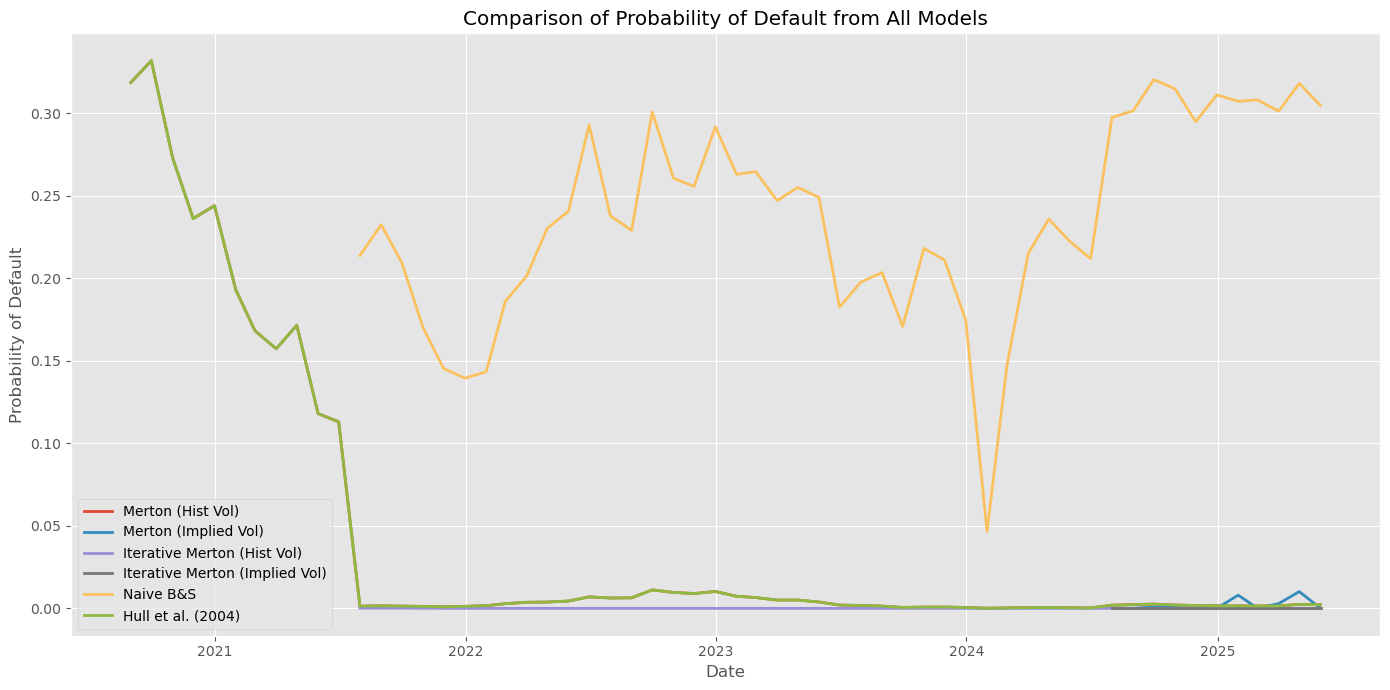

In [322]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Обновлённый словарь с правильным названием колонки Hull
model_columns = {
    "PD (Merton)": "Merton (Hist Vol)",
    "PD (Implied Vol)": "Merton (Implied Vol)",
    "PD (Iter HistVol)": "Iterative Merton (Hist Vol)",
    "PD (Iter ImplVol)": "Iterative Merton (Implied Vol)",
    "PD (Naive)": "Naive B&S",
    "PD (CreditGrades)": "CreditGrades",
    "PD (Hull)": "Hull et al. (2004)"
}

for col, label in model_columns.items():
    if col in df.columns:
        plt.plot(df.index, df[col], label=label, linewidth=2)

plt.title("Comparison of Probability of Default from All Models")
plt.xlabel("Date")
plt.ylabel("Probability of Default")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Analytical Interpretation: Comparing PDs from All Models

### General Observation

This combined plot reveals notable divergence in probability of default (PD) estimates produced by different structural credit risk models. While all aim to quantify default likelihood, results vary substantially depending on model inputs and methodology.

---

### Key Takeaways by Model:

#### Naïve B&S Approximation
- Consistently produces **higher PD values**, often exceeding 20–30%.  
- Does not consider the dynamic relationship between asset and equity volatility, leading to **systematic overestimation of credit risk**.  
- Reacts visibly to volatility changes but lacks precision in risk quantification.

#### Merton Model (Historical Volatility)
- Shows a steady decline in PD, falling below 5% after 2021.  
- Reflects past realized volatility, which causes lag in capturing rapid market shifts.  
- Suitable for longer-term risk trends but less sensitive to near-term signals.

#### Merton Model (Implied Volatility)
- Generally low PDs with somewhat higher sensitivity near 2025.  
- Better captures market sentiment and forward-looking uncertainty than historical volatility.  
- May underestimate risk during periods of low implied volatility.

#### Iterative Merton (Historical & Implied Volatility)
- Both versions display **very low PDs**, closely hugging the zero baseline.  
- Iterative feedback mechanisms stabilize asset value estimates, often resulting in conservative risk assessments.  
- Valuable for precise model calibration but may appear overly optimistic absent significant volatility shocks.

---

### Overall Insights

- The Naïve B&S approach provides a useful **upper bound or worst-case scenario** benchmark.  
- Models incorporating implied volatility offer a more **dynamic, market-informed risk perspective** but depend heavily on data quality.  
- Iterative estimation methods refine asset and volatility inputs, substantially reducing PD estimates — sometimes to the point of underestimation.

---

### Practical Use

- This comparison underscores the **critical importance of model selection** in credit risk evaluation.  
- Naïve B&S is appropriate for **quick screening** or conservative benchmarking, whereas iterative and implied volatility models suit **regulatory and investment-grade analysis**.  
- Robust credit risk management should involve **triangulation across multiple models** to balance forward-looking insight with conservative assessment.

---

## Comparing Probability of Default Across All Models

In this step, we consolidate the results from all previously developed structural credit risk models to visually compare their **Probability of Default (PD)** estimates over time.

---

### What This Chart Shows

This graph plots the monthly PD values computed using:

- **Merton Model (Historical Volatility)**  
- **Merton Model (Implied Volatility)**  
- **Iterative Merton Model (Historical Volatility)**  
- **Iterative Merton Model (Implied Volatility)**  
- **Naïve Black & Scholes Approximation**  
- **CreditGrades Model**  
- **Hull Model (2004)**

Each line reflects how a particular model estimates Ford’s credit risk at different time points.

---

### Why Compare All Models?

- To understand how different assumptions (e.g., historical vs. implied volatility) affect risk estimates.  
- To identify which models are more conservative or reactive in assessing PD.  
- To determine the **consistency or divergence** across different methodologies.

This comprehensive comparison supports assessment of **model robustness**, uncovers **market sensitivity**, and enables **more informed credit risk decision-making**.

---

*Tip: Use the interactive legend to isolate specific models or zoom into periods of interest for deeper insights.*

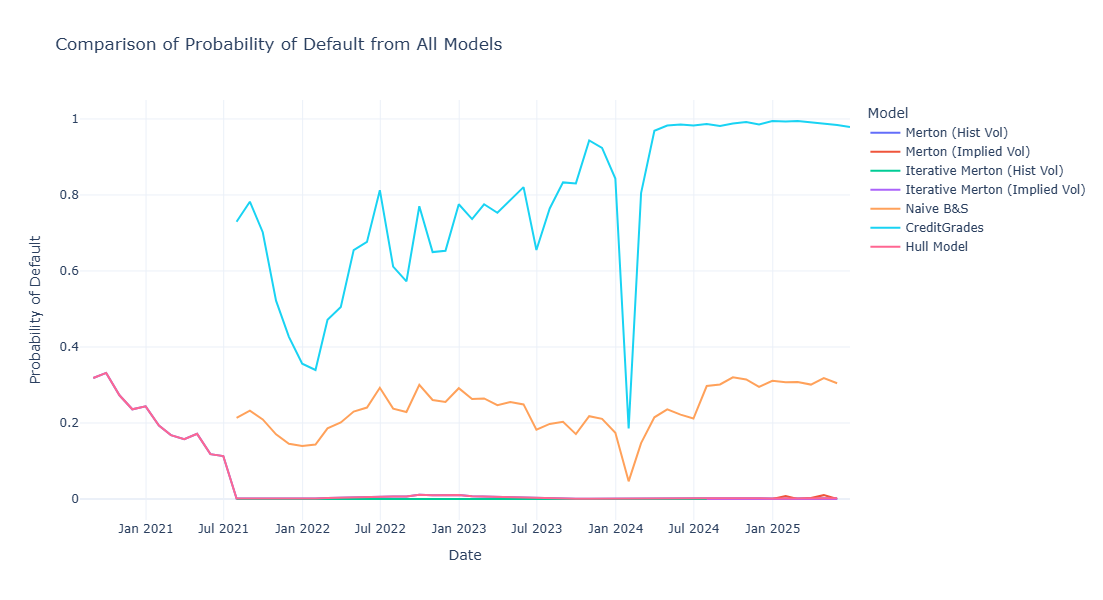

In [326]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces for each PD model
fig.add_trace(go.Scatter(x=df.index, y=df["PD (Merton)"], mode='lines', name='Merton (Hist Vol)'))
fig.add_trace(go.Scatter(x=df.index, y=df["PD (Implied Vol)"], mode='lines', name='Merton (Implied Vol)'))
fig.add_trace(go.Scatter(x=df.index, y=df["PD (Iter HistVol)"], mode='lines', name='Iterative Merton (Hist Vol)'))
fig.add_trace(go.Scatter(x=df.index, y=df["PD (Iter ImplVol)"], mode='lines', name='Iterative Merton (Implied Vol)'))
fig.add_trace(go.Scatter(x=df.index, y=df["PD (Naive)"], mode='lines', name='Naive B&S'))
fig.add_trace(go.Scatter(x=df.index, y=df["PD (CG)"], mode='lines', name='CreditGrades'))
fig.add_trace(go.Scatter(x=df.index, y=df["PD (Hull)"], mode='lines', name='Hull Model'))

# Layout settings
fig.update_layout(
    title="Comparison of Probability of Default from All Models",
    xaxis_title="Date",
    yaxis_title="Probability of Default",
    legend_title="Model",
    template="plotly_white",
    height=600
)

fig.show()

# **Final Analysis and Recommendations on Credit Risk Models**

Throughout this study, multiple structural credit risk models were applied to evaluate Ford Motor Company’s default risk from different methodological perspectives. Below is a detailed synthesis of key findings and practical guidance for using these models effectively.

---

## Key Findings by Model

### 1. Merton Model (Historical Volatility)
- Based on the classical structural framework using realized equity volatility.  
- Exhibits a steady decline in Probability of Default (PD) over time, reflecting improving fundamentals.  
- Well-suited for capturing long-term trends but tends to lag in identifying sudden market shifts due to its backward-looking nature.

### 2. Merton Model (Implied Volatility)
- Incorporates forward-looking market expectations through option-implied volatility.  
- More responsive to changing market sentiment, providing earlier warning signals of credit deterioration.  
- However, it may underestimate risk during periods of subdued implied volatility.

### 3. Iterative Merton Model (Historical & Implied Volatility)
- Employs an iterative approach to jointly estimate asset value and volatility, enhancing precision.  
- Produces more conservative and stable PD estimates by reducing noise inherent in raw equity data.  
- Recommended for regulatory compliance and detailed risk monitoring frameworks.

### 4. Naïve Black-Scholes Approximation
- A computationally efficient, closed-form approximation without iterative solving.  
- Generally yields higher PD estimates, especially in stable markets, due to simplified assumptions.  
- Useful as a quick screening tool but limited in capturing nuanced dynamics of credit risk.

### 5. CreditGrades Model
- Market-driven approach integrating recovery rates and a default barrier based on equity data.  
- Highly sensitive to equity volatility and capitalization, which can cause PD overestimation during volatile periods.  
- Valuable for rapid market-consistent risk assessment, yet should be complemented by more structurally grounded models.

### 6. Hull et al. (2004) Model
- Extends the Merton framework by allowing default to occur anytime before debt maturity (first-passage-time approach).  
- Offers balanced and realistic PD and credit spread estimates aligned with observed market behavior.  
- Ideal for pricing credit derivatives and for scenarios requiring a forward-looking default risk profile.

---

## General Recommendations for Model Usage

- **Adopt a multi-model approach.** No single model perfectly captures all facets of credit risk; combining insights improves robustness and confidence in assessments.  
- **Favor iterative and implied volatility-based models** for dynamic monitoring and early detection of credit deterioration.  
- Use **naïve approximations** as rapid, conservative benchmarks rather than definitive risk measures.  
- Apply **CreditGrades and Hull models** for market-consistent pricing and risk quantification, especially in volatile environments or for credit derivative valuation.  
- Perform **stress testing and scenario analysis** to assess model sensitivity to extreme events and structural breaks.  
- Where available, **validate model outputs against market data** such as CDS spreads or historical default rates to ensure practical relevance.

---

## Concluding Remarks

The diverse structural modeling approaches collectively portray Ford Motor Company as maintaining a strong credit profile with a declining default probability over the observed period. The nuanced differences between models highlight how assumptions regarding volatility, asset estimation, and default timing affect credit risk assessments.

By integrating multiple methodologies and carefully interpreting their results, credit risk professionals can develop a more comprehensive, realistic, and timely understanding of default risk — a critical foundation for sound risk management and strategic decision-making.

---

If desired, I can assist in embedding this section into your full report or tailoring it further to specific audiences or use cases.